In [3]:
#pySnowRadar modules
import sys
%matplotlib inline

# from pySnowRadar import SnowRadar
# from pySnowRadar.processing import extract_layers
# from pySnowRadar.algorithms import Wavelet_TN, Peakiness

from msc_thesis_functions import *
del sys.modules['msc_thesis_functions']
from msc_thesis_functions import *
import pickle

#Community packages
import os
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks
from datetime import datetime, timedelta
from thefuzz import process, fuzz
from scipy.spatial.distance import cdist
from tqdm import tqdm
import h5py
import cmasher as cmr
import xarray as xr
from scipy.stats import linregress
import matplotlib.colors as mcolors
from pyproj import Transformer
from shapely.geometry import Polygon, Point, MultiPoint, LineString
from shapely import affinity

import numpy as np
import shapely
import seaborn as sns
from pyproj import Transformer
transformer = Transformer.from_crs(4326, 3413, always_xy=True)


pd.options.mode.chained_assignment = None  # default='warn'

from matplotlib.colors import LinearSegmentedColormap

ncolors = 256
color_array = plt.get_cmap('Blues')(range(ncolors))
color_array[:,-1] = np.linspace(0.2,1,ncolors)
map_object = LinearSegmentedColormap.from_list(name='Blues_alpha',colors=color_array)
# 
# register this new colormap with matplotlib
# plt.colormaps.register(cmap=map_object)

from pyproj import Transformer
transformer = Transformer.from_crs(4326, 3413, always_xy=True)

from scipy.constants import speed_of_light


import matplotlib.font_manager as font_manager

font_path= '/Users/torka/Library/Fonts/FiraSans-Light.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

import geopandas as gpd

### LOADING ALL THE DATA

In [4]:
sites = [2, 3, 4, 'grid3', 'grid4', 'grid5', 'grid6', 'grid7', 'grid8']

#opening ATM grids
path_ATM= '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/ATM_gridded/gridding_v7'
files = os.listdir(path_ATM)
ATM_data_dict = {}
# print('Opening ATM data:')
for site in sites:
    file = [x for x in files if x.split('_')[-1].split('.')[0] == str(site)][0]
    # print(f'{site}: {file}')
    ds = xr.open_dataset(os.path.join(path_ATM, file))
    ATM_data_dict[site] = ds
# print('------------------')


#opening MP grids
path_MP = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/krigging_onATMgrid_v5_exactTrue'
files = os.listdir(path_MP)
files = [f for f in files if f.endswith('.nc')] 
MP_data_dict = {}
# MP_data_rolled_dict = {}

# print('Opening and rolling MP data:')
for site in sites:
    # MP_data_rolled_dict[site] = {}
    file = [x for x in files if x.split('_')[1] == str(site)][0]
    # print(f'{site}: {file}')
    ds = xr.open_dataset(os.path.join(path_MP, file))
    MP_data_dict[site] = ds
    # for r in rolling_windows:
    #     MP_data_rolled_dict[site][r] = ds.rolling(easting=r, northing=r, min_periods=r, center=True).mean()
# print('------------------')



#opening SR data (Wavelet)
path_SR_Wavelet = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/Wavelet/20250204_SRprecision'
SR_Wavelet_data_dict = {}
# print('Opening SR Wavelet data:')
for site in sites:
    SR_Wavelet_data_dict[site] = {}
    subpath = os.path.join(path_SR_Wavelet, str(site))
    for i, f in enumerate(os.listdir(subpath)):
        # print(f'{site}, {i}: {f}')
        ds = xr.open_dataset(os.path.join(path_SR_Wavelet, str(site), f))
        SR_Wavelet_data_dict[site][i] = ds
# print('------------------')


#opening SR data (Peakiness)
path_SR_Peakiness = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/Peakiness/20250204_SRprecision'
SR_Peakiness_data_dict = {}
# print('Opening SR Peakiness data:')

for site in sites:
    SR_Peakiness_data_dict[site] = {}
    subpath = os.path.join(path_SR_Peakiness, str(site))
    for i, f in enumerate(os.listdir(subpath)):
        # print(f'{site}, {i}: {f}')
        ds = xr.open_dataset(os.path.join(path_SR_Peakiness, str(site), f))
        SR_Peakiness_data_dict[site][i] = ds
        
        
#opening SR data (Quicklook)
path_SR_Quicklook = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/Quicklook/subset'
files = os.listdir(path_SR_Quicklook)
files = np.sort(files)
QL_dict = {}
for i, site in enumerate(sites):
    df = pd.read_csv(os.path.join(path_SR_Quicklook, files[i]), index_col=0)
    df['site'] = [site]*len(df)
    df.reset_index(inplace=True)
    QL_dict[site] = df[['x','y','snow_depth','snow_depth_unc','site']]



#opening shapefiles
path_shapefiles = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/grid_extents_v4'
shape_dict = {}
for site in sites:
    file = [x for x in os.listdir(path_shapefiles) if x.split('_')[1] == str(site) and x.endswith('shp')][0]
    # print(f'{site}: {file}')

    shape_dict[site] = gpd.read_file(os.path.join(path_shapefiles, file))

In [47]:

############
# 
footprint_mode = 'pulse_limited_unfocused'
include_moving_windows = True

if include_moving_windows:
    moving_windows = [3,5,7,9,11,13,17,21,25]
    
############

df_master_dict = {}
df_tmp_dict = {}

for site in tqdm(sites):
    df_tmp_dict[site] = {}
    
    for i in SR_Wavelet_data_dict[site].keys():
        ds =  SR_Wavelet_data_dict[site][i]
        df_tmp = SR_Wavelet_data_dict[site][i].to_dataframe().loc[0]
        
        df_tmp_tmp = SR_Peakiness_data_dict[site][i].to_dataframe().loc[0]
        df_tmp_tmp.reset_index(inplace=True)
        
        df_tmp['air_snow_elevation_peakiness'] = df_tmp_tmp['air_snow_elevation'].to_list()
        df_tmp['snow_ice_elevation_peakiness'] = df_tmp_tmp['snow_ice_elevation'].to_list()
        df_tmp['snow_depth_peakiness'] = df_tmp_tmp['snow_depth'].to_list()
        
        if include_moving_windows:
            for length in moving_windows:
                df_tmp[f'snow_depth_rolled_{length}'] = df_tmp['snow_depth'].rolling(window=length, min_periods=1, center=True).mean()
                df_tmp[f'snow_depth_peakiness_rolled_{length}'] = df_tmp['snow_depth_peakiness'].rolling(window=length, min_periods=1, center=True).mean()
            
        # print()
        waveforms = []
        for k in range(len(df_tmp)):
            waveforms.append(SR_Wavelet_data_dict[site][i]['radar_data'].values[:,k])
            
        df_tmp['waveform'] = waveforms 
        
        df_tmp.reset_index(inplace=True)
        # break
        #add site, ice age and overflight information
        df_tmp['site'] = [site] * len(df_tmp)    
        df_tmp['ice_age'] = df_tmp['site'].apply(lambda x: 'myi' if x=='grid8' or x=='grid5' else 'fyi') 
        df_tmp['overflight_nr'] = [i] * len(df_tmp) 

        #add footprints
        df_tmp, sr_footprints = construct_footprints_theoretical(df_tmp, ds, mode=footprint_mode)
        # sr_footprints = [affinity.scale(fp, xfact=scale, yfact=scale) for fp in sr_footprints]
        
        df_tmp['footprints'] = sr_footprints
        df_tmp['footprint_area'] = df_tmp['footprints'].apply(lambda x: x.area)

        xx, yy = np.meshgrid(ATM_data_dict[site]['easting'], ATM_data_dict[site]['northing'], indexing='xy')
        zz_ATM = ATM_data_dict[site]['elevation'].values.flatten()

        mask = ~np.isnan(zz_ATM)
        xx = xx.flatten()[mask]
        yy = yy.flatten()[mask]

        poly_points_indices_wavelet = points_in_poly_list(df_tmp['footprints'], list(zip(xx, yy)), np.mean(df_tmp['footprint_area']) * .65 if footprint_mode == 'pulse_limited_unfocused' else 1)
        wavelet_indices = list(poly_points_indices_wavelet.keys())
        df_tmp = df_tmp.loc[wavelet_indices] #delete not fully-covered footprints

        df_tmp['grid_indices'] = poly_points_indices_wavelet
        df_tmp['grid_x'] = df_tmp['grid_indices'].apply(lambda x: xx[x])
        df_tmp['grid_y'] = df_tmp['grid_indices'].apply(lambda x: yy[x])
        df_tmp['grid_dists'] = df_tmp.apply(lambda x: np.sqrt((x.grid_x - x.x)**2 + (x.grid_y - x.y)**2), axis=1)        

        # add ATM 
        df_tmp['ATM_elev'] = df_tmp['grid_indices'].apply(lambda x: ATM_data_dict[site]['elevation'].values.flatten()[mask][x])
        df_tmp['ATM_elev_uncertainty'] = df_tmp['grid_indices'].apply(lambda x: ATM_data_dict[site]['standard_deviation'].values.flatten()[mask][x])    
        df_tmp['ATM_htopo'] = df_tmp['ATM_elev'].apply(lambda x: np.quantile(x, .95) - np.quantile(x, .05))
        df_tmp['ATM_slope'] = df_tmp['grid_indices'].apply(lambda x: ATM_data_dict[site]['slope'].values.flatten()[mask][x])
        df_tmp['ATM_roughness'] = df_tmp['grid_indices'].apply(lambda x: ATM_data_dict[site]['roughness'].values.flatten()[mask][x])
        df_tmp['deformation'] = df_tmp['grid_indices'].apply(lambda x: ATM_data_dict[site]['classes'].values.flatten()[mask][x])
        df_tmp['deformation_flag'] = df_tmp['deformation'].apply(lambda x: 1 if np.nanmedian(x) > .1 else 0)

        # add MP
        df_tmp['MP_snow_depth'] = df_tmp['grid_indices'].apply(lambda x: MP_data_dict[site]['snow_depth'].values.flatten()[mask][x])
        df_tmp['MP_snow_depth_uncertainty'] = df_tmp['grid_indices'].apply(lambda x: MP_data_dict[site]['snow_depth_uncertainty'].values.flatten()[mask][x])
        
        if include_moving_windows:
            for length in moving_windows:
                df_tmp[f'MP_snow_depth_rolled_{length}'] = roll_MP_snow_depth(df_tmp, var='MP_snow_depth', window_size=length)
                df_tmp[f'MP_snow_depth_uncertainty_rolled_{length}'] = roll_MP_snow_depth(df_tmp, var='MP_snow_depth_uncertainty', window_size=length)
                df_tmp[f'ATM_elev_rolled_{length}'] = roll_MP_snow_depth(df_tmp, var='ATM_elev', window_size=length)
            
        offset_wavelet = np.mean(df_tmp['air_snow_elevation'] - df_tmp['ATM_elev'].apply(lambda x: np.quantile(x, .5)))
        offset_peakiness = np.mean(df_tmp['air_snow_elevation_peakiness'] - df_tmp['ATM_elev'].apply(lambda x: np.quantile(x, .5)))
        
        df_tmp['ATM_elev_wavelet'] = df_tmp['ATM_elev'].apply(lambda x: x + offset_wavelet)
        df_tmp['ATM_elev_peakiness'] = df_tmp['ATM_elev'].apply(lambda x: x + offset_peakiness)

        df_tmp = df_tmp.loc[(abs(df_tmp['roll']) < 3) & abs((df_tmp['pitch']) < 3)]
        df_tmp = df_tmp.loc[df_tmp['MP_snow_depth'].apply(lambda x: len(x[~np.isnan(x)]) > 10)]

        df_tmp.reset_index(inplace=True, drop=True)
        
        if len (df_tmp) > 0:
            df_tmp_dict[site][i] = df_tmp
        
            if i == list(SR_Wavelet_data_dict[site].keys())[0]:
                df_master = df_tmp
            else:
                df_master = pd.concat([df_master, df_tmp], axis=0)
            
        df_master.reset_index(inplace=True, drop=True)
        
    if site == 2:
        df_supermaster = df_master
    else:
        df_supermaster = pd.concat([df_supermaster, df_master], axis=0)
        
    df_master_dict[site] = df_master
    
df_supermaster.reset_index(inplace=True, drop=True)


df_supermaster['snow_depth_MAX'] = df_supermaster['ATM_elev'].apply(lambda x: np.nanmean(x)) -  df_supermaster['max_elevation']

100%|██████████| 9/9 [08:53<00:00, 59.28s/it]


Load QL data product, construct footprint and add ATM, MP etc

In [40]:
footprint_mode = 'GSFC'
include_moving_windows = True

for site in tqdm(sites):
    df_tmp = QL_dict[site]
    df_tmp['ice_age'] = df_tmp['site'].apply(lambda x: 'myi' if x=='grid8' or x=='grid5' else 'fyi') 
    
    df_tmp, sr_ql_footprints = construct_footprints_theoretical(df_tmp, ds, mode=footprint_mode)
    df_tmp['footprints'] = sr_ql_footprints
    df_tmp['footprint_area'] = df_tmp['footprints'].apply(lambda x: x.area)
    
    if include_moving_windows:
        for length in moving_windows:
            df_tmp[f'snow_depth_rolled_{length}'] = df_tmp['snow_depth'].rolling(window=length, min_periods=1, center=True).mean()
            
    xx, yy = np.meshgrid(ATM_data_dict[site]['easting'], ATM_data_dict[site]['northing'], indexing='xy')
    zz_ATM = ATM_data_dict[site]['elevation'].values.flatten()

    mask = ~np.isnan(zz_ATM)
    xx = xx.flatten()[mask]
    yy = yy.flatten()[mask]

    poly_points_indices_wavelet = points_in_poly_list(df_tmp['footprints'], list(zip(xx, yy)), np.mean(df_tmp['footprint_area']) * .9)
    wavelet_indices = list(poly_points_indices_wavelet.keys())
    df_tmp = df_tmp.loc[wavelet_indices] #delete not fully-covered footprints

    df_tmp['grid_indices'] = poly_points_indices_wavelet
    df_tmp['grid_x'] = df_tmp['grid_indices'].apply(lambda x: xx[x])
    df_tmp['grid_y'] = df_tmp['grid_indices'].apply(lambda x: yy[x])
    df_tmp['grid_dists'] = df_tmp.apply(lambda x: np.sqrt((x.grid_x - x.x)**2 + (x.grid_y - x.y)**2), axis=1)        

    # add ATM 
    df_tmp['ATM_elev'] = df_tmp['grid_indices'].apply(lambda x: ATM_data_dict[site]['elevation'].values.flatten()[mask][x])
    df_tmp['ATM_elev_uncertainty'] = df_tmp['grid_indices'].apply(lambda x: ATM_data_dict[site]['standard_deviation'].values.flatten()[mask][x])    
    df_tmp['ATM_htopo'] = df_tmp['ATM_elev'].apply(lambda x: np.quantile(x, .95) - np.quantile(x, .05))
    df_tmp['ATM_slope'] = df_tmp['grid_indices'].apply(lambda x: ATM_data_dict[site]['slope'].values.flatten()[mask][x])
    df_tmp['ATM_roughness'] = df_tmp['grid_indices'].apply(lambda x: ATM_data_dict[site]['roughness'].values.flatten()[mask][x])
    df_tmp['deformation'] = df_tmp['grid_indices'].apply(lambda x: ATM_data_dict[site]['classes'].values.flatten()[mask][x])
    df_tmp['deformation_flag'] = df_tmp['deformation'].apply(lambda x: 1 if np.nanmedian(x) > .1 else 0)

    # add MP
    df_tmp['MP_snow_depth'] = df_tmp['grid_indices'].apply(lambda x: MP_data_dict[site]['snow_depth'].values.flatten()[mask][x])
    df_tmp['MP_snow_depth_uncertainty'] = df_tmp['grid_indices'].apply(lambda x: MP_data_dict[site]['snow_depth_uncertainty'].values.flatten()[mask][x])
    
    if include_moving_windows:
        for length in moving_windows:
            df_tmp[f'MP_snow_depth_rolled_{length}'] = roll_MP_snow_depth(df_tmp, var='MP_snow_depth', window_size=length)
            df_tmp[f'MP_snow_depth_uncertainty_rolled_{length}'] = roll_MP_snow_depth(df_tmp, var='MP_snow_depth_uncertainty', window_size=length)
            df_tmp[f'ATM_elev_rolled_{length}'] = roll_MP_snow_depth(df_tmp, var='ATM_elev', window_size=length)
            
    QL_dict[site] = df_tmp
    
    if site == 2:
        df_supermaster_QL = df_tmp
    else:
        df_supermaster_QL = pd.concat([df_supermaster_QL, df_tmp], axis=0)
        
df_supermaster_QL.reset_index(inplace=True, drop=True)

 56%|█████▌    | 5/9 [00:21<00:14,  3.51s/it]/var/folders/33/mb4rwg392ds1fw9l8rx1tnp80000gn/T/ipykernel_79777/2850267382.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_supermaster_QL = pd.concat([df_supermaster_QL, df_tmp], axis=0)
100%|██████████| 9/9 [00:41<00:00,  4.59s/it]


### QUICKLOOK MOVING AVERAGE COMPARISON



In [13]:
Rs = []
RMSEs = []
BIASs = []
# sites_2014 = [2,3,4]
# sites_2016 = ['grid3', 'grid4', 'grid5', 'grid6', 'grid7', 'grid8']

for length in moving_windows:
    print(length)
    mask = (df_supermaster_QL['deformation_flag'] == 0) &  (df_supermaster_QL['ice_age'] == 'fyi') #& (df_supermaster['site'].isin(sites))
    x = df_supermaster_QL[f'MP_snow_depth_rolled_{length}'].apply(lambda x: np.nanquantile(x,.5))[mask]
    
    y = df_supermaster_QL[f'snow_depth_rolled_{length}'][mask]
    
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    
    linr = linregress(x, y)
    Rs.append(linr.rvalue)
    RMSEs.append(linr.stderr)
    BIASs.append(np.nanmean(y - x))

Rs = np.array(Rs)
RMSEs = np.array(RMSEs)
BIASs = np.array(BIASs)




3
5
7
9
11
13
17
21
25


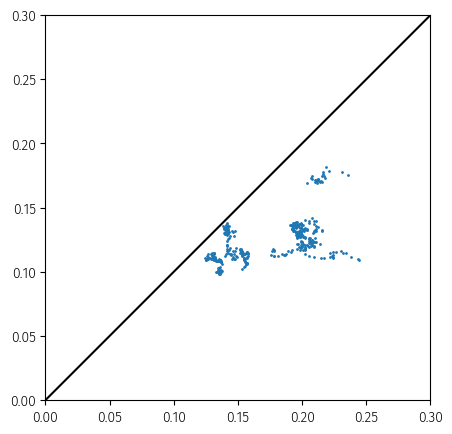

In [22]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.set_aspect('equal')
ax.scatter(x,y,s=1)
ax.set_xlim(0,.3)
ax.set_ylim(0,.3)
ax.plot([0,.3],[0,.3], color='k')

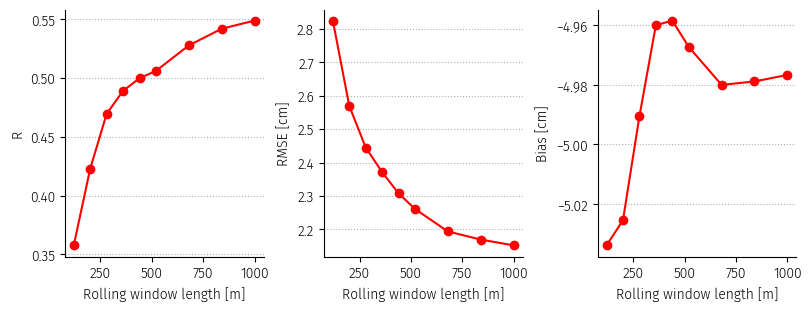

In [15]:

fig, ax = plt.subplots(1, 3, figsize=(8,3), constrained_layout=True)

ax[0].plot(np.multiply(moving_windows, 40), Rs, label='R', marker='o', color='red')
ax[1].plot(np.multiply(moving_windows, 40), RMSEs * 100, marker='o', color='red')
ax[2].plot(np.multiply(moving_windows, 40), BIASs * 100, marker='o', color='red')

ax[0].set_ylabel('R')
ax[1].set_ylabel('RMSE [cm]')
ax[2].set_ylabel('Bias [cm]')

for i in range(len(ax)):
    ax[i].set_xlabel('Rolling window length [m]')
    ax[i].grid(ls=':', axis='y')
    ax[i].spines['top'].set_color('white')
    ax[i].spines['right'].set_color('white')

### COMPARE OVER-LAPPING FOOTPRINTS

In [48]:
from shapely.geometry import Polygon
from shapely.ops import unary_union

# Initialize lists to store indices of overlapping footprints
x_indices = []
y_indices = []
area_of_overlap = []
# Initialize a set to keep track of added pairs
added_pairs = set()

# Iterate through each site
for site in sites:
    # Filter the dataframe for the current site
    site_df = df_supermaster[df_supermaster['site'] == site]
    
    # Iterate through each pair of footprints
    for i in trange(len(site_df)):
        for j in range(i + 1, len(site_df)):
            # Check if the footprints are from the same overflight
            if site_df.iloc[i]['overflight_nr'] == site_df.iloc[j]['overflight_nr']:
                continue
            
            poly1 = site_df.iloc[i]['footprints']
            poly2 = site_df.iloc[j]['footprints']
            
            # Calculate the intersection area
            intersection_area = poly1.intersection(poly2).area
            
            # Check if the intersection area is more than 50% of either footprint's area
            if intersection_area > 0.5 * poly1.area or intersection_area > 0.5 * poly2.area:
                pair = (site_df.index[i], site_df.index[j])
                # Ensure the pair is only added once
                if pair not in added_pairs and (pair[1], pair[0]) not in added_pairs:
                    x_indices.append(pair[0])
                    y_indices.append(pair[1])
                    area_of_overlap.append(intersection_area / np.mean([poly1.area, poly2.area]))
                    added_pairs.add(pair)
                
# Print the indices of overlapping footprints
print("x_indices:", x_indices)
print("y_indices:", y_indices)

  0%|          | 0/910 [00:00<?, ?it/s]

  0%|          | 0/1155 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/1226 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/747 [00:00<?, ?it/s]

  0%|          | 0/769 [00:00<?, ?it/s]

  0%|          | 0/263 [00:00<?, ?it/s]

x_indices: [1215, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2266, 2304, 2305, 2306, 2307, 2308, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2324, 2325, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2332, 2333, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2341, 2342, 2343, 2344, 2345, 2346, 2537, 2966, 2966, 2966, 2967, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2975, 2975, 2976, 2976, 2976, 2977, 2977, 2977, 2978, 2978, 2978, 2979, 2979, 2979, 2980, 2980, 2980, 2981, 2981, 2981, 2982, 2982, 2983, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2990, 2990, 2991, 2991, 2991, 2992, 2992, 2992, 2993, 2993, 2993, 2994, 2994, 2994, 2995, 2995, 2995, 2996, 2996, 2996, 2996, 2997, 2997, 2997, 2998, 2998, 2998, 2999, 3000, 3001, 3002, 3003

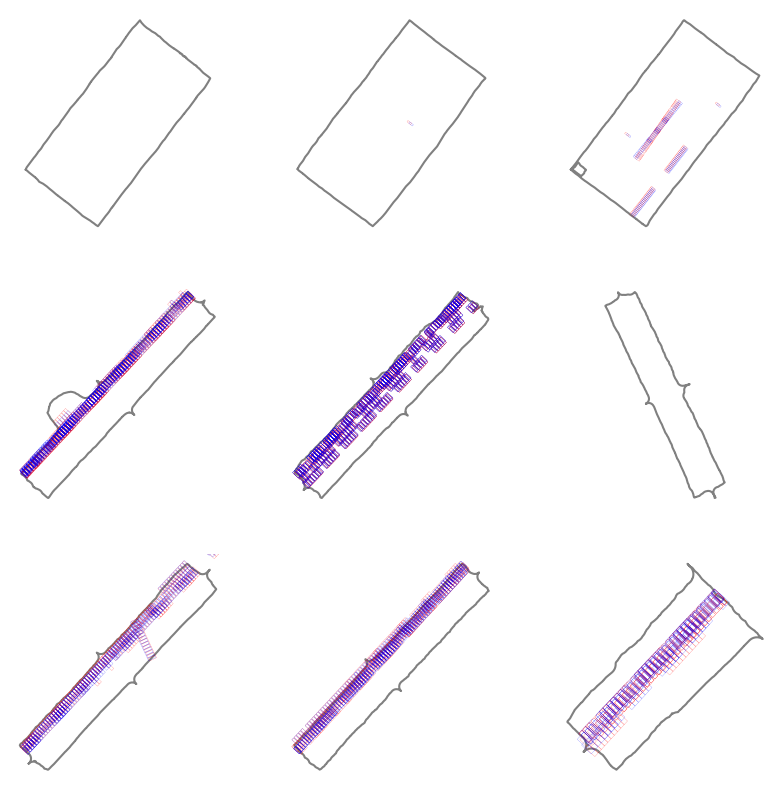

In [49]:
fig, ax = plt.subplots(3,3,figsize=(10, 10))
ax = ax.ravel()


for i,site in enumerate(sites):
    
    ax[i].plot(*shape_dict[site].loc[0,'geometry'].exterior.xy, color='grey')
    xlim = ax[i].get_xlim()
    ylim = ax[i].get_ylim()
    
    for xind in x_indices:
        ax[i].plot(*df_supermaster.loc[xind, 'footprints'].exterior.xy, color='red',lw=.1)
    for yind in y_indices:
        ax[i].plot(*df_supermaster.loc[yind, 'footprints'].exterior.xy, color='blue',lw=.1)
        
    ax[i].set_xlim(xlim)
    ax[i].set_ylim(ylim)
    
    ax[i].set_aspect('equal')
    ax[i].axis('off')

Text(0, 0.5, 'Snow depth [m]')

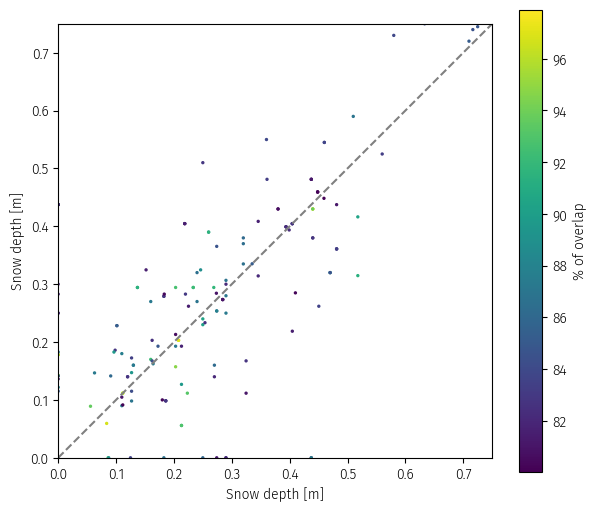

In [ ]:
from scipy.odr import ODR, Model, Data, RealData

fig,ax = plt.subplots(1,2,figsize=(7,6))
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

x = df_supermaster.loc[x_indices]['snow_depth_peakiness_rolled_3']
y = df_supermaster.loc[y_indices]['snow_depth_peakiness_rolled_3']
c = np.array(area_of_overlap)
mask = (c >= 0.80)
c = c[mask]
x = x[mask]
y = y[mask]
def linear_func(B, x):
    return B[0] * x + B[1]

linear_model = Model(linear_func)
xs = np.linspace(0, .75, 100)
data = RealData(x, y)
odr = ODR(data, linear_model, beta0=[1., 0.])
odr_res = odr.run()
linr = odr_res
ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
# ax.plot(xs, linear_func(linr.beta, xs), color='black')

scat = ax.scatter(x, y, c=c*100, s=2)
# ax.text(0.1, 0.9, f"R = {linr.rvalue:.2f}", transform=ax.transAxes)

ax.set_xlim(0,.75)
ax.set_ylim(0,.75)

fig.colorbar(scat, ax=ax, label='% of overlap')

ax.set_xlabel('Snow depth [m]')
ax.set_ylabel('Snow depth [m]')

compare the waveforms

Text(0.98, 0.1, 'In-situ snow depth = 0.27 m\nSnow depth1 = 0.37 m\nSnow depth2 = 0.30 m')

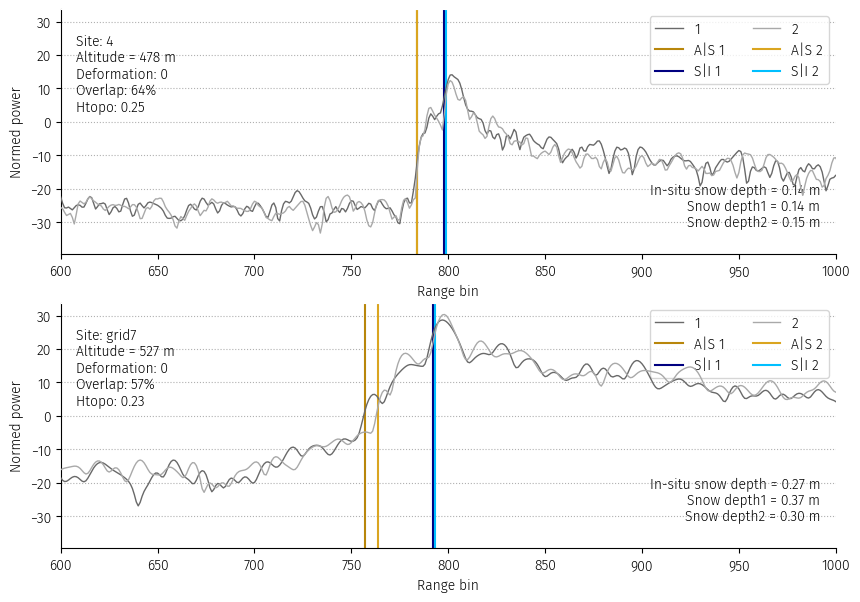

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(10,7), sharey=True)
i = np.random.randint(0,len(x_indices))
i = 30
xind = x_indices[i]
yind = y_indices[i]

ax[0].plot(10*np.log10(df_supermaster.loc[xind, 'waveform']), label='1', color='dimgrey',lw=1,zorder=100)

ax[0].axvline(df_supermaster.loc[xind, 'air_snow_index'], color='darkgoldenrod', label='A|S 1')
ax[0].axvline(df_supermaster.loc[xind, 'snow_ice_index'], color='navy', label='S|I 1')

ax[0].plot(10*np.log10(df_supermaster.loc[yind, 'waveform']), label='2', color='darkgrey',lw=1,zorder=100)
ax[0].axvline(df_supermaster.loc[yind, 'air_snow_index'], color='goldenrod', label='A|S 2')
ax[0].axvline(df_supermaster.loc[yind, 'snow_ice_index'], color='deepskyblue', label='S|I 2')
ax[0].legend(loc='upper right',ncol=2)

ax[0].set_xlim(600,1000)

ax[0].grid(ls=':', axis='y')
ax[0].spines['top'].set_color('white')
ax[0].spines['right'].set_color('white')

ax[0].set_xlabel('Range bin')
ax[0].set_ylabel('Normed power')

site = df_supermaster.loc[xind, 'site']
atm_htopo  = df_supermaster.loc[xind, 'ATM_htopo']
deformation = df_supermaster.loc[xind, 'deformation_flag']
altitude = df_supermaster.loc[xind, 'altitude']

insitu_snow_depth = np.nanquantile(df_supermaster.loc[xind, 'MP_snow_depth'], .8)
snow_depth1 = df_supermaster.loc[xind, 'snow_depth']
snow_depth2 = df_supermaster.loc[yind, 'snow_depth']

ax[0].text(0.02, 0.9, f"Site: {site}\nAltitude = {altitude:.0f} m\nDeformation: {deformation}\nOverlap: {area_of_overlap[i]*100:.0f}%\nHtopo: {atm_htopo:.2f}\n", transform=ax[0].transAxes,  ha='left', va='top')
ax[0].text(0.98, 0.1, f"In-situ snow depth = {insitu_snow_depth:.2f} m\nSnow depth1 = {snow_depth1:.2f} m\nSnow depth2 = {snow_depth2:.2f} m", transform=ax[0].transAxes,  ha='right', va='bottom')


i=2500
xind = x_indices[i]
yind = y_indices[i]

ax[1].plot(10*np.log10(df_supermaster.loc[xind, 'waveform']) , label='1', color='dimgrey',lw=1,zorder=100)

ax[1].axvline(df_supermaster.loc[xind, 'air_snow_index'], color='darkgoldenrod', label='A|S 1')
ax[1].axvline(df_supermaster.loc[xind, 'snow_ice_index'], color='navy', label='S|I 1')

ax[1].plot(10*np.log10(df_supermaster.loc[yind, 'waveform']) , label='2', color='darkgrey',lw=1,zorder=100)
ax[1].axvline(df_supermaster.loc[yind, 'air_snow_index'], color='goldenrod', label='A|S 2')
ax[1].axvline(df_supermaster.loc[yind, 'snow_ice_index'], color='deepskyblue', label='S|I 2')
ax[1].legend(loc='upper right',ncol=2)

ax[1].set_xlim(600,1000)

ax[1].grid(ls=':', axis='y')
ax[1].spines['top'].set_color('white')
ax[1].spines['right'].set_color('white')

ax[1].set_xlabel('Range bin')
ax[1].set_ylabel('Normed power')

site = df_supermaster.loc[xind, 'site']
atm_htopo  = df_supermaster.loc[xind, 'ATM_htopo']
deformation = df_supermaster.loc[xind, 'deformation_flag']
altitude = df_supermaster.loc[xind, 'altitude']

insitu_snow_depth = np.nanquantile(df_supermaster.loc[xind, 'MP_snow_depth'], .8)
snow_depth1 = df_supermaster.loc[xind, 'snow_depth']
snow_depth2 = df_supermaster.loc[yind, 'snow_depth']
ax[1].text(0.02, 0.9, f"Site: {site}\nAltitude = {altitude:.0f} m\nDeformation: {deformation}\nOverlap: {area_of_overlap[i]*100:.0f}%\nHtopo: {atm_htopo:.2f}\n", transform=ax[1].transAxes,  ha='left', va='top')
ax[1].text(0.98, 0.1, f"In-situ snow depth = {insitu_snow_depth:.2f} m\nSnow depth1 = {snow_depth1:.2f} m\nSnow depth2 = {snow_depth2:.2f} m", transform=ax[1].transAxes,  ha='right', va='bottom')

### TESTING on 26th, 27th january

In [44]:
Rs = []
RMSEs = []
BIASs = []
# sites_2014 = [2,3,4]
# sites_2016 = ['grid3', 'grid4', 'grid5', 'grid6', 'grid7', 'grid8']

for length in moving_windows:
    print(length)
    mask = (df_supermaster['deformation_flag'] == 0) &  (df_supermaster['ice_age'] == 'fyi') #& (df_supermaster['site'].isin(sites))
    x = df_supermaster[f'MP_snow_depth_rolled_{length}'].apply(lambda x: np.nanquantile(x,.5))[mask]
    
    y = df_supermaster[f'snow_depth_rolled_{length}'][mask]
    
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    
    linr = linregress(x, y)
    Rs.append(linr.rvalue)
    RMSEs.append(linr.stderr)
    BIASs.append(np.nanmean(y - x))

Rs = np.array(Rs)
RMSEs = np.array(RMSEs)
BIASs = np.array(BIASs)




3
5
7
9
11
13
17
21
25


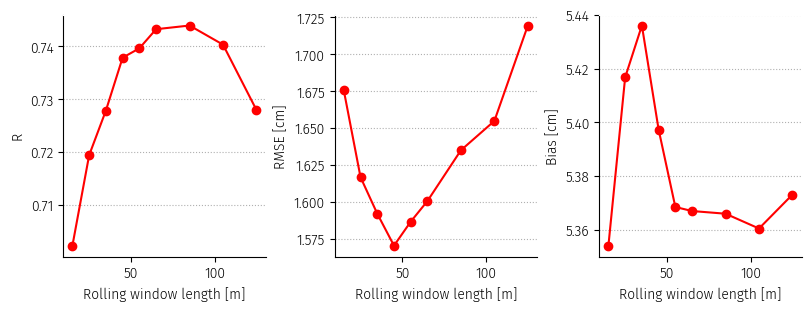

In [45]:

fig, ax = plt.subplots(1, 3, figsize=(8,3), constrained_layout=True)

ax[0].plot(np.multiply(moving_windows, 5), Rs, label='R', marker='o', color='red')
ax[1].plot(np.multiply(moving_windows, 5), RMSEs * 100, marker='o', color='red')
ax[2].plot(np.multiply(moving_windows, 5), BIASs * 100, marker='o', color='red')

ax[0].set_ylabel('R')
ax[1].set_ylabel('RMSE [cm]')
ax[2].set_ylabel('Bias [cm]')

for i in range(len(ax)):
    ax[i].set_xlabel('Rolling window length [m]')
    ax[i].grid(ls=':', axis='y')
    ax[i].spines['top'].set_color('white')
    ax[i].spines['right'].set_color('white')

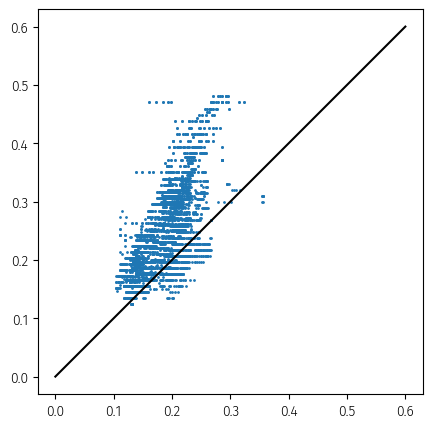

In [46]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.set_aspect('equal')
ax.scatter(x,y,s=1)
# ax.set_xlim(0,.3)
# ax.set_ylim(0,.3)
ax.plot([0,.6],[0,.6], color='k')

### PLOT OF CORRELATION FOR FYI, UNDEFORMED WITH UNCERTAINTIES

(0.0, 0.9)

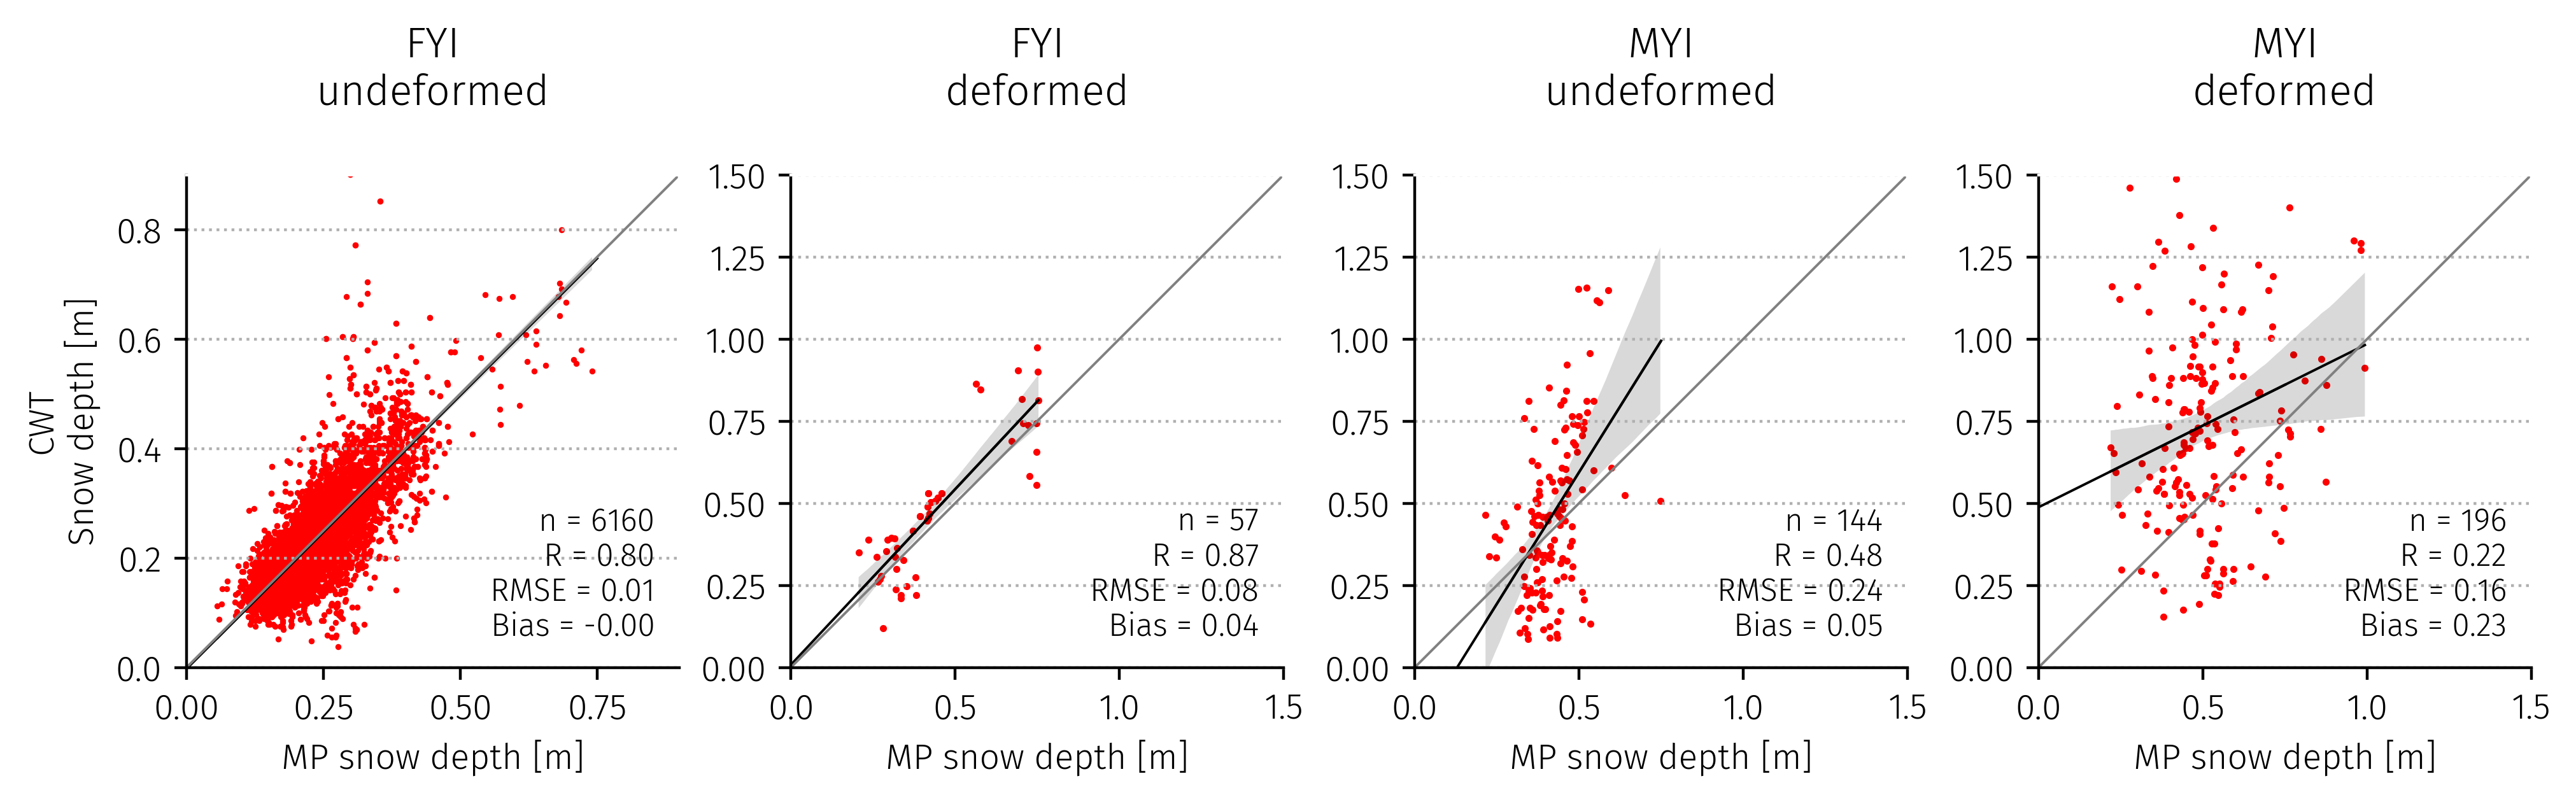

In [112]:
fig, ax = plt.subplots(1, 4, figsize=(10, 5), dpi=400, constrained_layout=True)
roll = 3
q = .9

var = f'snow_depth_rolled_{roll}'
# var = 'snow_depth_peakiness'
cmaps = [ sns.color_palette("light:magenta", as_cmap=True), sns.color_palette("light:red", as_cmap=True), sns.color_palette("light:blue", as_cmap=True), sns.color_palette("light:saddlebrown", as_cmap=True)]
    
ax[0].set_title('FYI\nundeformed', y=1.1)
ax[1].set_title('FYI\ndeformed', y=1.1)
ax[2].set_title('MYI\nundeformed', y=1.1)
ax[3].set_title('MYI\ndeformed', y=1.1)
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[2].set_aspect('equal')
ax[3].set_aspect('equal')

# mask = (df_supermaster['ice_age'] == 'fyi') & (df_supermaster['deformation_flag'] == 0)
# x = df_supermaster['MP_snow_depth'].apply(lambda x: np.nanquantile(x,.9))[mask]
# y = df_supermaster['snow_depth'][mask]
# ax[0].scatter(x,y)


mask = (df_supermaster['ice_age'] == 'fyi') & (df_supermaster['deformation_flag'] == 0)
x = df_supermaster[f'MP_snow_depth_rolled_{roll}'].apply(lambda x: np.nanquantile(x,q))[mask]
y = df_supermaster[var][mask]
mask2 = ~np.isnan(x) & ~np.isnan(y)
x = x[mask2]
y = y[mask2]
ax[0].scatter(x,y, s=.5, color='red')

# sns.histplot(x=x,y=y,ax=ax[0],
#             cmap=cmaps[1],
#             bins=30,
#             binwidth=.02,
#             cbar=True,
#             stat='count',
#             cbar_kws={'shrink': .35, 'label': 'count'},

#             )
linr = linregress(x,y)
ax[0].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
sns.regplot(x=x, y=y, ax=ax[0], scatter=False, color='black', line_kws={'lw':.7})

n= len(x)
bias = np.nanmean(y-x)
ax[0].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[0].transAxes, ha='right', va='bottom', size=9)

# uncertainties= {}
# for k in np.arange(0,1,0.02):
#   if len(y[(x > k-0.01) & (x < k + .01)]) > 5:
#     ax[0].errorbar(k, np.mean(y[(x > k-0.01) & (x < k + .01)]), yerr= np.std(y[(x > k-0.01) & (x < k + .01)]), color='black', capsize=1, capthick=.5, lw=.5)
#     uncertainties[k] = np.std(y[(x > k-0.01) & (x < k + .01)])
    
###################

mask = (df_supermaster['ice_age'] == 'fyi') & (df_supermaster['deformation_flag'] == 1)
x = df_supermaster[f'MP_snow_depth_rolled_{roll}'].apply(lambda x: np.nanquantile(x,q))[mask]
y = df_supermaster[var][mask]
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]
x = x[y>0]
y = y[y>0]
ax[1].scatter(x,y, s=1, color='red')
linr = linregress(x,y)
ax[1].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
sns.regplot(x=x, y=y, ax=ax[1], scatter=False, color='black', line_kws={'lw':.7})

n= len(x)
bias = np.nanmean(y-x)
ax[1].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[1].transAxes, ha='right', va='bottom', size=9)


#######

mask = (df_supermaster['ice_age'] == 'myi') & (df_supermaster['deformation_flag'] == 0)
x = df_supermaster[f'MP_snow_depth_rolled_{roll}'].apply(lambda x: np.nanquantile(x,q))[mask]
y = df_supermaster[var][mask]
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]
x = x[y>0]
y = y[y>0]
ax[2].scatter(x,y, s=1, color='red')

linr = linregress(x,y)
ax[2].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
sns.regplot(x=x, y=y, ax=ax[2], scatter=False, color='black', line_kws={'lw':.7})

n= len(x)
bias = np.nanmean(y-x)
ax[2].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[2].transAxes, ha='right', va='bottom', size=9)


#######

mask = (df_supermaster['ice_age'] == 'myi') & (df_supermaster['deformation_flag'] == 1)
x = df_supermaster[f'MP_snow_depth_rolled_{roll}'].apply(lambda x: np.nanquantile(x,q))[mask]
y = df_supermaster[var][mask]
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]
x = x[y>0]
y = y[y>0]
ax[3].scatter(x,y, s=1, color='red')

linr = linregress(x,y)
ax[3].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
sns.regplot(x=x, y=y, ax=ax[3], scatter=False, color='black', line_kws={'lw':.7})

n= len(x)
bias = np.nanmean(y-x)
ax[3].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[3].transAxes, ha='right', va='bottom', size=9)


for i in range(len(ax)):
    ax[i].spines['top'].set_color('white')
    ax[i].spines['right'].set_color('white')
    ax[i].grid(ls=':',axis='y')
    ax[i].set_aspect('equal')
    # ax[i].set_ylabel('SR snow depth [m]')
    ax[i].set_xlim([0, 1.5])
    ax[i].set_ylim([0, 1.5])
    ax[i].plot([0, 1.5], [0, 1.5], color='grey',lw=.7)

    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    
ax[0].set_ylabel('CWT\nSnow depth [m]')
# ax[1].set_ylabel('CWT, Snow depth [m]')
# ax[2].set_ylabel('CWT, Snow depth [m]')
# ax[3].set_ylabel('CWT, Snow depth [m]')

# ax[0].set_xlabel('MP snow depth\n(90% quantile) [m]')
# ax[1].set_xlabel('MP snow depth\n(90% quantile) [m]')
# ax[2].set_xlabel('MP snow depth\n(90% quantile) [m]')
# ax[3].set_xlabel('MP snow depth\n(90% quantile) [m]')

ax[0].set_xlabel('MP snow depth [m]')
ax[1].set_xlabel('MP snow depth [m]')
ax[2].set_xlabel('MP snow depth [m]')
ax[3].set_xlabel('MP snow depth [m]')


ax[0].set_xlim([0, .9])
ax[0].set_ylim([0, .9])

### CORRELATION BETWEEN CWT AND PEAK

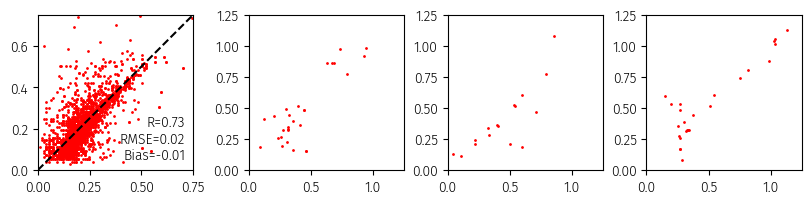

In [93]:
fig, ax = plt.subplots(1, 4, figsize=(8,3), constrained_layout=True)

for i in range(len(ax)):
    ax[i].set_aspect('equal')
    ax[i].set_xlim([0, 1.25])
    ax[i].set_ylim([0, 1.25])

ax[0].set_xlim(0,.75)
ax[0].set_ylim(0,.75)
    
mask = (df_supermaster['deformation_flag'] == 0) &  (df_supermaster['ice_age'] == 'fyi') #& (df_supermaster['site'].isin(sites))
x = df_supermaster['snow_depth'][mask]
y = df_supermaster['snow_depth_peakiness'][mask]

mask = ~np.isnan(x) & ~np.isnan(y) 
x = x[mask]
y = y[mask]
x = x[y > 0]
y = y[y > 0]
linr = linregress(x, y)

ax[0].scatter(x, y, s=1, color='red')
ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes, color='black', ls='--')
ax[0].text(0.95, 0.05, f'R={linr.rvalue:.2f}\nRMSE={linr.stderr:.2f}\nBias={np.nanmean(y - x):.2f}', transform=ax[0].transAxes, ha='right', va='bottom')

mask = (df_supermaster['deformation_flag'] == 1) &  (df_supermaster['ice_age'] == 'fyi') #& (df_supermaster['site'].isin(sites))
x = df_supermaster['snow_depth'][mask]
y = df_supermaster['snow_depth_peakiness'][mask]

mask = ~np.isnan(x) & ~np.isnan(y) 
x = x[mask]
y = y[mask]
x = x[y > 0]
y = y[y > 0]
linr = linregress(x, y)

ax[1].scatter(x, y, s=1, color='red')

mask = (df_supermaster['deformation_flag'] == 0) &  (df_supermaster['ice_age'] == 'myi') #& (df_supermaster['site'].isin(sites))
x = df_supermaster['snow_depth'][mask]
y = df_supermaster['snow_depth_peakiness'][mask]

mask = ~np.isnan(x) & ~np.isnan(y) 
x = x[mask]
y = y[mask]
x = x[y > 0]
y = y[y > 0]
linr = linregress(x, y)

ax[2].scatter(x, y, s=1, color='red')


mask = (df_supermaster['deformation_flag'] == 1) &  (df_supermaster['ice_age'] == 'myi') #& (df_supermaster['site'].isin(sites))
x = df_supermaster['snow_depth'][mask]
y = df_supermaster['snow_depth_peakiness'][mask]

mask = ~np.isnan(x) & ~np.isnan(y) 
x = x[mask]
y = y[mask]
x = x[y > 0]
y = y[y > 0]
linr = linregress(x, y)

ax[3].scatter(x, y, s=1, color='red')




### CORRELATION PER YEAR

/opt/anaconda3/envs/landlab/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/opt/anaconda3/envs/landlab/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/opt/anaconda3/envs/landlab/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


Text(0.5, 0, 'MP snow depth [m]')

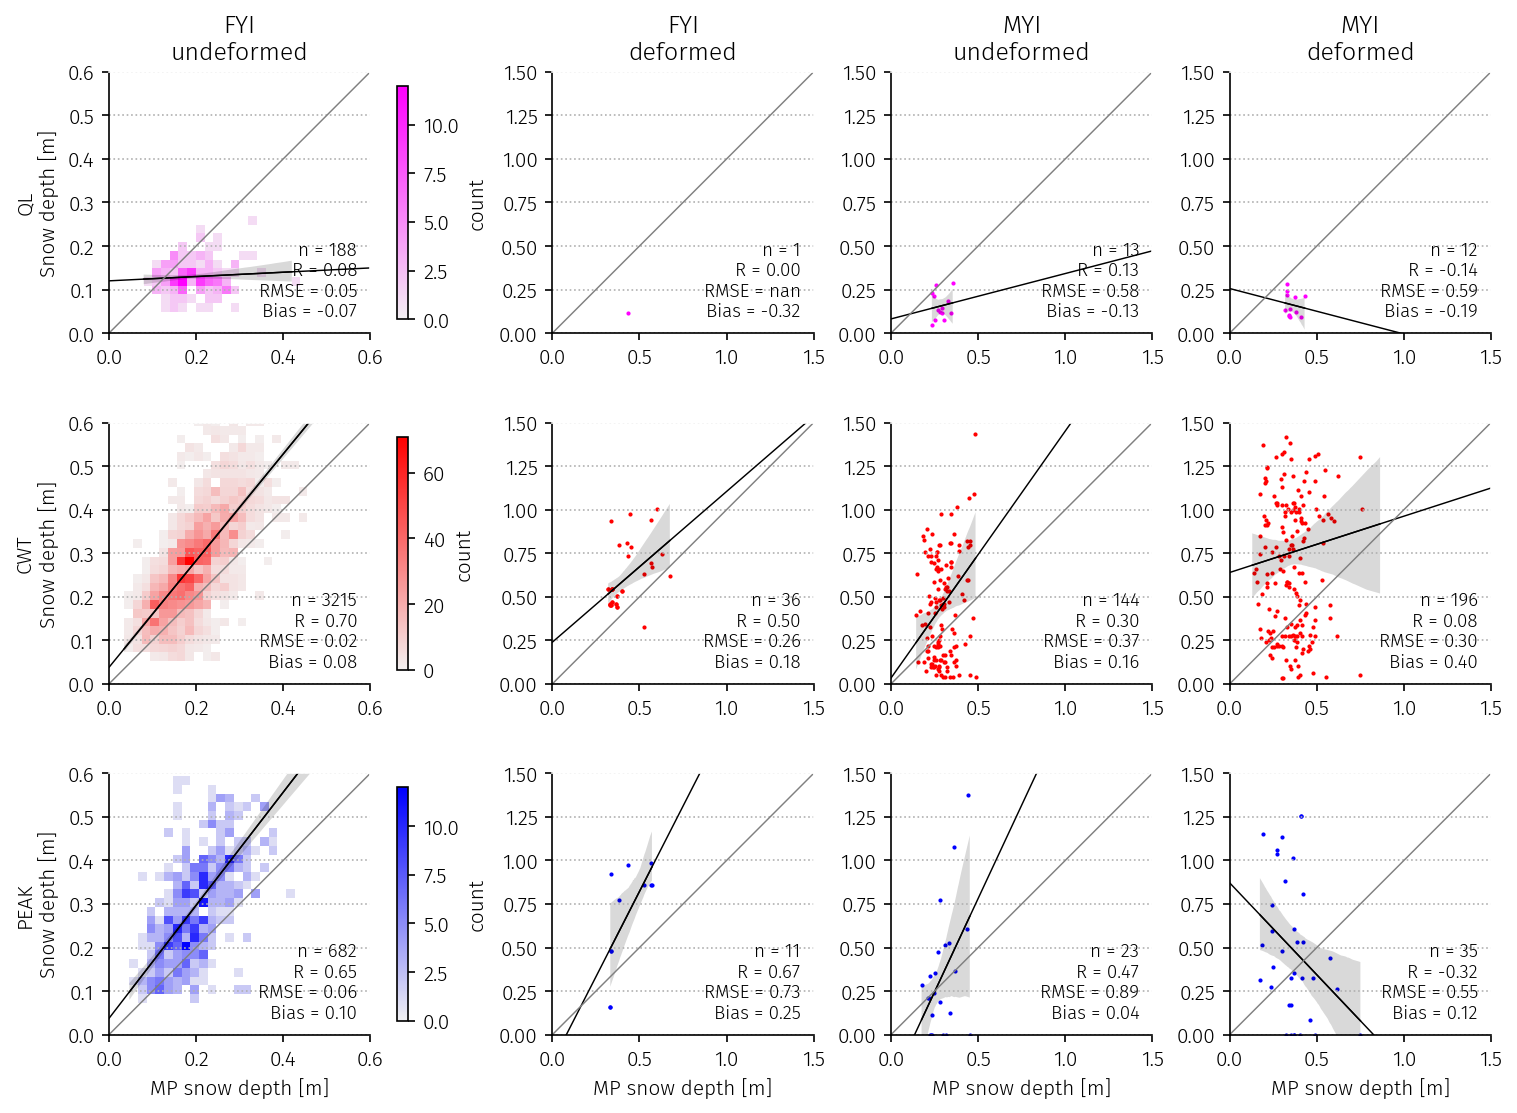

In [30]:
year = 2016

if year == 2014:
  sites = [2,3,4]
elif year == 2016:
  sites = ['grid3', 'grid4', 'grid5', 'grid6', 'grid7', 'grid8']
  
fig, ax = plt.subplots(3,4, constrained_layout=True, figsize=(10,7.4), dpi=150)
xs = np.linspace(0,1.5,100)
colors = ['magenta', 'red', 'blue', 'saddlebrown']
cmaps = [ sns.color_palette("light:magenta", as_cmap=True), sns.color_palette("light:red", as_cmap=True), sns.color_palette("light:blue", as_cmap=True), sns.color_palette("light:saddlebrown", as_cmap=True)]

ax = ax.ravel()
ax[0].set_title('FYI\nundeformed', y=1)
ax[1].set_title('FYI\ndeformed', y=1)
ax[2].set_title('MYI\nundeformed', y=1)
ax[3].set_title('MYI\ndeformed', y=1)

k = 0
color_k = 0

for var in ['snow_depth_QL', 'snow_depth',  'snow_depth_peakiness']:
  
  if var == 'snow_depth_QL':
    mask = (df_supermaster_QL['ice_age'] == 'fyi') & (df_supermaster_QL['deformation_flag'] == 0 ) & (df_supermaster_QL['site'].isin(sites))
    x = df_supermaster_QL['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]
    y = df_supermaster_QL['snow_depth'][mask]
    
    hist = sns.histplot(x=x,y=y,ax=ax[k],
                cmap=cmaps[color_k],
                bins=30,
                binwidth=.02,
                cbar=True,
                cbar_kws={'shrink': .7, 'label': 'count'},
                stat='count'
                )
    linr = linregress(x,y)
    ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
    sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
    n= len(x)
    bias = np.nanmean(y-x)
    ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
    k+=1
    
    mask = (df_supermaster_QL['ice_age'] == 'fyi') & (df_supermaster_QL['deformation_flag'] == 1)
    x = df_supermaster_QL['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]
    y = df_supermaster_QL['snow_depth'][mask]
    c = df_supermaster_QL['deformation'].apply(lambda x: np.nanmean(x))[mask]
    ax[k].scatter(x, y,
                  color=colors[color_k],
                  s=1
                  )
    if len(x) > 0:
      linr = linregress(x,y)
      ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
      sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
    
      n= len(x)
      bias = np.nanmean(y-x)
      ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
    k+=1

    mask = (df_supermaster_QL['ice_age'] == 'myi') & (df_supermaster_QL['deformation_flag'] == 0) & (df_supermaster_QL['site'].isin(sites))
    x = df_supermaster_QL['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]
    y = df_supermaster_QL['snow_depth'][mask]
    c = df_supermaster_QL['deformation'].apply(lambda x: np.nanmean(x))[mask]
    ax[k].scatter(x, y,
                  color=colors[color_k],
                  s=1
                  )
    if len(x) > 0:
    
      linr = linregress(x,y)
      ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
      sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
      
      n= len(x)
      bias = np.nanmean(y-x)
      ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
    k+=1

    mask = (df_supermaster_QL['ice_age'] == 'myi') & (df_supermaster_QL['deformation_flag'] == 1) & (df_supermaster_QL['site'].isin(sites))
    x = df_supermaster_QL['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]
    y = df_supermaster_QL['snow_depth'][mask]
    c = df_supermaster_QL['deformation'].apply(lambda x: np.nanmean(x))[mask]
    ax[k].scatter(x, y,
                  color=colors[color_k],
                  s=1
                  )
    if len(x) > 0:
    
      linr = linregress(x,y)
      ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
      sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
      
      n= len(x)
      bias = np.nanmean(y-x)
      ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
    k+=1
    color_k+=1
    
  else:
    
    mask = (df_supermaster['ice_age'] == 'fyi') & (df_supermaster['deformation_flag'] == 0) & (df_supermaster['site'].isin(sites))
    x = df_supermaster['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]
    y = df_supermaster[var][mask]
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)]
    x = x[y>0]
    y = y[y>0]
    
    # scat = ax[0].scatter(x, y,
    #             #          c=c,
    #             #   cmap='Reds_r',
    #             #   vmin=0, vmax=1,
    #               s=1
    #               )
    sns.histplot(x=x,y=y,ax=ax[k],
                cmap=cmaps[color_k],
                bins=30,
                binwidth=.02,
                cbar=True,
                stat='count',
                cbar_kws={'shrink': .7, 'label': 'count'},

                )
    linr = linregress(x,y)
    ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
    sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
    
    n= len(x)
    bias = np.nanmean(y-x)
    ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
        
    k+=1
    mask = (df_supermaster['ice_age'] == 'fyi') & (df_supermaster['deformation_flag'] == 1) & (df_supermaster['site'].isin(sites))
    x = df_supermaster['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]
    y = df_supermaster[var][mask]
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)]
    # c = df_supermaster['deformation'].apply(lambda x: np.nanmean(x))[mask]
    ax[k].scatter(x, y,
                  color=colors[color_k],
                  s=1
                  )
    linr = linregress(x,y)
    ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
    sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
    
    n= len(x)
    bias = np.nanmean(y-x)
    ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
    k+=1

    mask = (df_supermaster['ice_age'] == 'myi') & (df_supermaster['deformation_flag'] == 0) & (df_supermaster['site'].isin(sites))
    x = df_supermaster['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]
    y = df_supermaster[var][mask]
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)]
    # c = df_supermaster['deformation'].apply(lambda x: np.nanmean(x))[mask]
    ax[k].scatter(x, y,
                  color=colors[color_k],
                  s=1
                  )
    if len(x) > 0:
    
      linr = linregress(x,y)
      ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
      sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
      
      n= len(x)
      bias = np.nanmean(y-x)
      ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
    k+=1

    mask = (df_supermaster['ice_age'] == 'myi') & (df_supermaster['deformation_flag'] == 1) & (df_supermaster['site'].isin(sites))
    x = df_supermaster['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]
    y = df_supermaster[var][mask]
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)]
    # c = df_supermaster['deformation'].apply(lambda x: np.nanmean(x))[mask]
    ax[k].scatter(x, y,
                  color=colors[color_k],
                  s=1
                  )
    if len(x) > 0:
    
      linr = linregress(x,y)
      sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
      
      ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
      n= len(x)
      bias = np.nanmean(y-x)
      ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
    k+=1
    color_k+=1
  
 
for i in range(len(ax)):
    ax[i].spines['top'].set_color('white')
    ax[i].spines['right'].set_color('white')
    ax[i].grid(ls=':',axis='y')
    ax[i].set_aspect('equal')
    # ax[i].set_ylabel('SR snow depth [m]')
    ax[i].set_xlim([0, 1.5])
    ax[i].set_ylim([0, 1.5])
    ax[i].plot([0, 1.5], [0, 1.5], color='grey',lw=.7)

    ax[i].set_xlabel('')
    ax[i].set_ylabel('')

ax[0].set_xlim([0, .6])
ax[0].set_ylim([0, .6])
ax[0].set_ylabel('QL\nSnow depth [m]')

ax[4].set_xlim([0, .6])
ax[4].set_ylim([0, .6])
ax[4].set_ylabel('CWT\nSnow depth [m]')

ax[8].set_xlim([0, .6])
ax[8].set_ylim([0, .6])
ax[8].set_ylabel('PEAK\nSnow depth [m]')

# ax[12].set_xlim([0, .6])
# ax[12].set_ylim([0, .6])
# ax[12].set_ylabel('MAX\nSnow depth [m]')


ax[8].set_xlabel('MP snow depth [m]')
ax[9].set_xlabel('MP snow depth [m]')
ax[10].set_xlabel('MP snow depth [m]')
ax[11].set_xlabel('MP snow depth [m]')


### HISTOGRAMS OF SNOW DEPTHS (2014 and 2016)

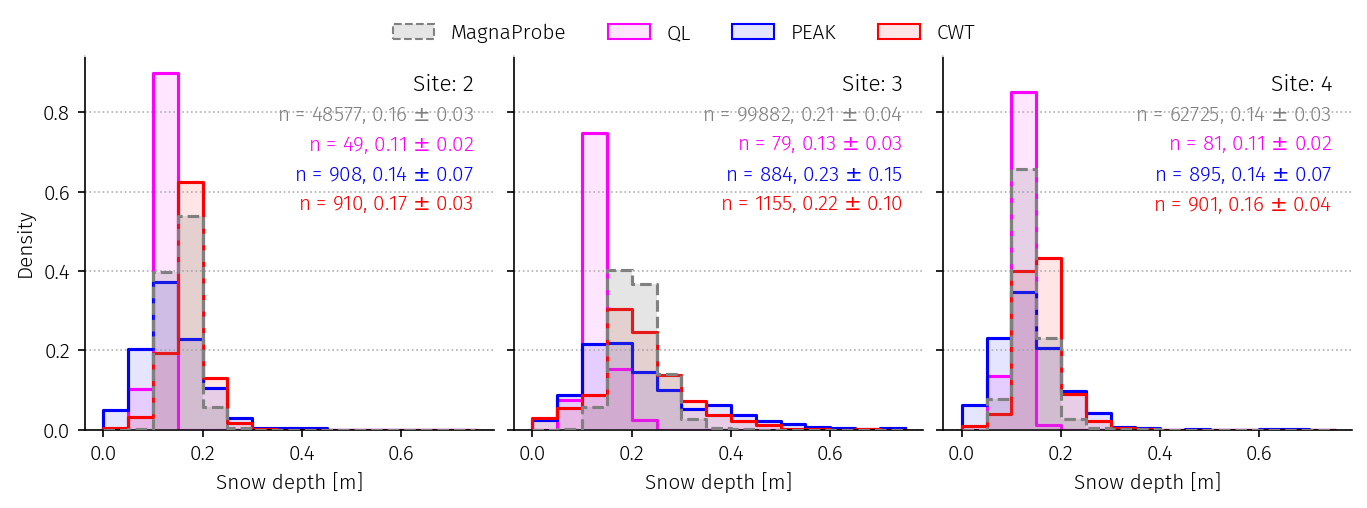

/opt/anaconda3/envs/landlab/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Text(0, 0.5, 'Density')

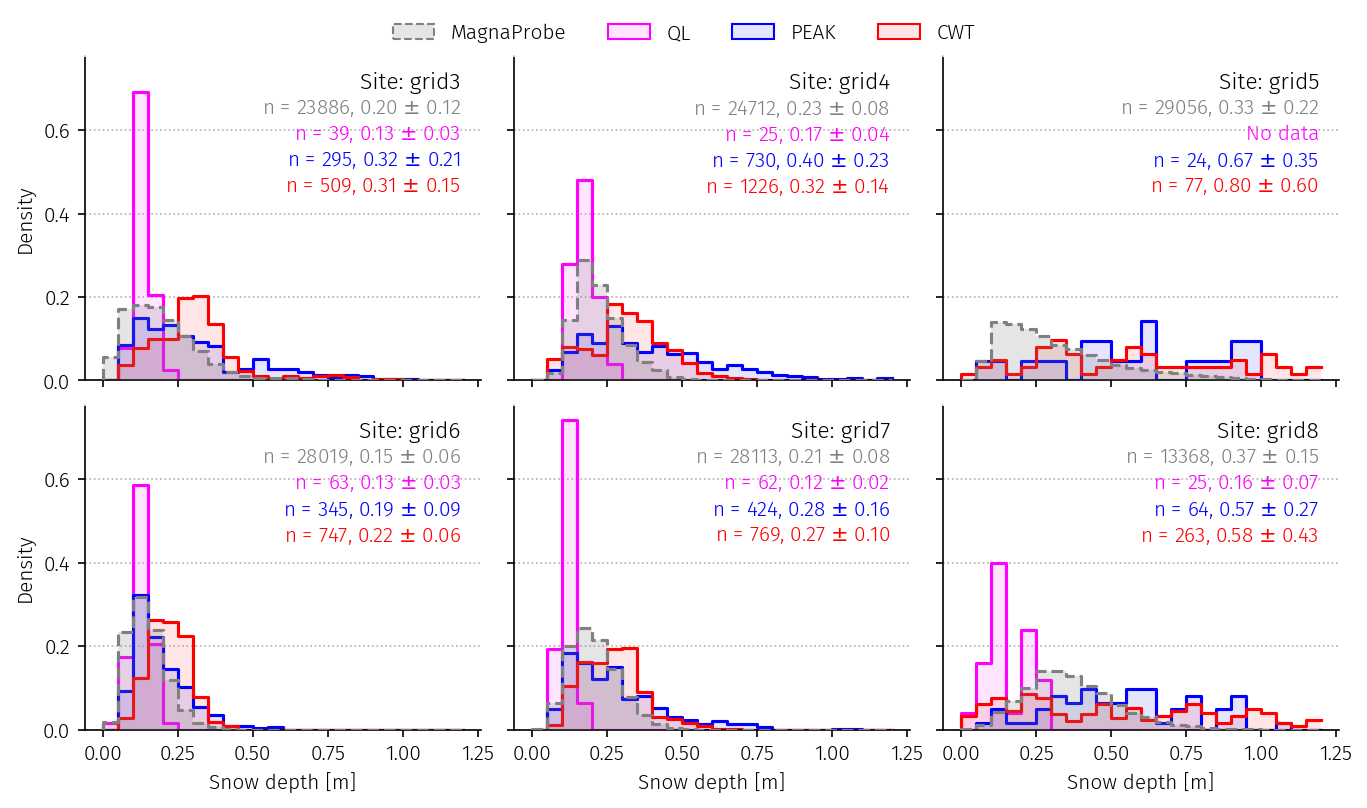

In [139]:
from matplotlib.patches import Patch

sites_2014 = [2,3,4]

fig, ax = plt.subplots(1,3, figsize=(9,3), sharey=True, sharex=True, constrained_layout=True, dpi=150)
ax = ax.ravel()
bw = 0.05
bin_edges = np.arange(0,.8,bw)
bc = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2

for i in range(len(ax)):
    ax[i].spines['top'].set_color('white')
    ax[i].spines['right'].set_color('white')
    ax[i].grid(ls=':',axis='y')
    
ax[0].set_xlabel('Snow depth [m]')
ax[1].set_xlabel('Snow depth [m]')
ax[2].set_xlabel('Snow depth [m]')

for i, site in enumerate(sites_2014):
    df_f = df_supermaster.loc[df_supermaster['site'] == site]
    df_f.reset_index(inplace=True, drop=True)
    
    #Kriged MagnaProbe snow depths
    hist, bin_edges = np.histogram(MP_data_dict[site]['snow_depth'].values, bins=bin_edges, density=True)
    ax[i].step([0]+list(bc+bw/2), [0]+list(hist*bw),color='grey', ls='--',zorder=200)
    t = ax[i].bar(bc, hist*bw,
                width=bw,
                alpha=.2,
                color='grey',zorder=100
                )
    ax[i].text(0.95, 0.95, f'Site: {site}', transform=ax[i].transAxes, ha='right', va='top', size=11)
    
    n = len(MP_data_dict[site]['snow_depth'].values[~np.isnan(MP_data_dict[site]['snow_depth'])])
    mean = np.nanmean(MP_data_dict[site]['snow_depth'])
    std = np.nanstd(MP_data_dict[site]['snow_depth'])
    ax[i].text(0.95, 0.87, f'n = {n}, {mean:.2f} $\pm$ {std:.2f}', transform=ax[i].transAxes, ha='right', va='top', color='grey')
    
    
    #QLOOK
    hist, bin_edges = np.histogram(QL_dict[site]['snow_depth'], bins=bin_edges, density=True)
    ax[i].step([0]+list(bc+bw/2), [0]+list(hist*bw),color='magenta')
    t = ax[i].bar(bc, hist*bw,
                width=bw,
                alpha=.1,
                color='magenta',
                )
    
    n = len(QL_dict[site]['snow_depth'])
    mean = np.nanmean(QL_dict[site]['snow_depth'])
    std = np.nanstd(QL_dict[site]['snow_depth'])
    ax[i].text(0.95, 0.79, f'n = {n}, {mean:.2f} $\pm$ {std:.2f}', transform=ax[i].transAxes, ha='right', va='top', color='magenta')
    
    
    
    #PEAK
    hist, bin_edges = np.histogram(df_f['snow_depth_peakiness'], bins=bin_edges, density=True)
    ax[i].step([0]+list(bc+bw/2), [0]+list(hist*bw),color='blue')
    t = ax[i].bar(bc, hist*bw,
                width=bw,
                alpha=.1,
                color='blue',
                )
    n = len(df_f['snow_depth_peakiness'].loc[~np.isnan(df_f['snow_depth_peakiness'])])
    mean = np.nanmean(df_f['snow_depth_peakiness'])
    std = np.nanstd(df_f['snow_depth_peakiness'])
    ax[i].text(0.95, 0.71, f'n = {n}, {mean:.2f} $\pm$ {std:.2f}', transform=ax[i].transAxes, ha='right', va='top', color='blue')
    
    # #MAX
    # hist, bin_edges = np.histogram(df_f['ATM_elev'].apply(lambda x: np.nanmedian(x)) - df_f['max_elevation'], bins=bin_edges, density=True)
    # ax[i].step([0]+list(bc+bw/2), [0]+list(hist*bw),color='saddlebrown')
    # t = ax[i].bar(bc, hist*bw,
    #             width=bw,
    #             alpha=.1,
    #             color='saddlebrown',
    #             )
    # n = len(df_f['max_elevation'].loc[~np.isnan(df_f['max_elevation'])])
    # mean = np.nanmean(df_f['ATM_elev'].apply(lambda x: np.nanmedian(x)) - df_f['max_elevation'])
    # std = np.nanstd(df_f['ATM_elev'].apply(lambda x: np.nanmedian(x)) - df_f['max_elevation'])
    # ax[i].text(0.95, 0.63, f'n = {n}, {mean:.2f} $\pm$ {std:.2f}', transform=ax[i].transAxes, ha='right', va='top', color='saddlebrown')
    
    #WAVELET
    hist, bin_edges = np.histogram(df_f['snow_depth'], bins=bin_edges, density=True)
    ax[i].step([0]+list(bc+bw/2), [0]+list(hist*bw),color='red')
    t = ax[i].bar(bc, hist*bw,
                width=bw,
                alpha=.1,
                color='red',
                )
    n = len(df_f['snow_depth'].loc[~np.isnan(df_f['snow_depth'])])
    mean = np.nanmean(df_f['snow_depth'])
    std = np.nanstd(df_f['snow_depth'])
    ax[i].text(0.95, 0.63, f'n = {n}, {mean:.2f} $\pm$ {std:.2f}', transform=ax[i].transAxes, ha='right', va='top', color='red')
    

legend_elements = [Patch(facecolor=mcolors.to_rgba('grey', alpha=.2), edgecolor='grey', label='MagnaProbe', linestyle='--'),
                   Patch(facecolor=mcolors.to_rgba('magenta', alpha=.1), edgecolor='magenta', label='QL'),
                  Patch(facecolor=mcolors.to_rgba('blue', alpha=.1), edgecolor='blue', label='PEAK'),
                    # Patch(facecolor=mcolors.to_rgba('saddlebrown', alpha=.1), edgecolor='saddlebrown', label='MAX'),
                   Patch(facecolor=mcolors.to_rgba('red', alpha=.1), edgecolor='red', label='CWT'),
                   ]

fig.legend(handles=legend_elements, ncols=5, loc='upper center', bbox_to_anchor=(0.5, 1.1), frameon=False)
# fig.legend(handles=legend_elements)
ax[0].set_ylabel('Density')
plt.show()





####

# 2016

###
sites_2016 = ['grid3', 'grid4', 'grid5', 'grid6', 'grid7', 'grid8']


fig, ax = plt.subplots(2,3, figsize=(9,5), sharey=True, sharex=True, constrained_layout=True, dpi=150)
ax = ax.ravel()
bw = 0.05
bin_edges = np.arange(0,1.25,bw)
bc = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2

for i in range(len(ax)):
    ax[i].spines['top'].set_color('white')
    ax[i].spines['right'].set_color('white')
    ax[i].grid(ls=':',axis='y')
    
ax[3].set_xlabel('Snow depth [m]')
ax[4].set_xlabel('Snow depth [m]')
ax[5].set_xlabel('Snow depth [m]')

for i, site in enumerate(sites_2016):
    df_f = df_supermaster.loc[df_supermaster['site'] == site]
    df_f.reset_index(inplace=True, drop=True)
    
    #Kriged MagnaProbe snow depths
    hist, bin_edges = np.histogram(MP_data_dict[site]['snow_depth'].values, bins=bin_edges, density=True)
    ax[i].step([0]+list(bc+bw/2), [0]+list(hist*bw),color='grey', ls='--',zorder=200)
    t = ax[i].bar(bc, hist*bw,
                width=bw,
                alpha=.2,
                color='grey',zorder=100
                )
    ax[i].text(0.95, 0.95, f'Site: {site}', transform=ax[i].transAxes, ha='right', va='top', size=11)
    
    n = len(MP_data_dict[site]['snow_depth'].values[~np.isnan(MP_data_dict[site]['snow_depth'])])
    mean = np.nanmean(MP_data_dict[site]['snow_depth'])
    std = np.nanstd(MP_data_dict[site]['snow_depth'])
    ax[i].text(0.95, 0.87, f'n = {n}, {mean:.2f} $\pm$ {std:.2f}', transform=ax[i].transAxes, ha='right', va='top', color='grey')
    
    #QLOOK
    hist, bin_edges = np.histogram(QL_dict[site]['snow_depth'], bins=bin_edges, density=True)
    ax[i].step([0]+list(bc+bw/2), [0]+list(hist*bw),color='magenta')
    t = ax[i].bar(bc, hist*bw,
                width=bw,
                alpha=.1,
                color='magenta',
                )
    if site != 'grid5':
        n = len(QL_dict[site]['snow_depth'])
        mean = np.nanmean(QL_dict[site]['snow_depth'])
        std = np.nanstd(QL_dict[site]['snow_depth'])
        ax[i].text(0.95, 0.79, f'n = {n}, {mean:.2f} $\pm$ {std:.2f}', transform=ax[i].transAxes, ha='right', va='top', color='magenta')
    else:
        ax[i].text(0.95, 0.79, f'No data', transform=ax[i].transAxes, ha='right', va='top', color='magenta')
        
    
    #PEAK
   
    hist, bin_edges = np.histogram( df_f.loc[df_f['snow_depth_peakiness']> 0, 'snow_depth_peakiness'], bins=bin_edges, density=True)
    ax[i].step([0]+list(bc+bw/2), [0]+list(hist*bw),color='blue')
    t = ax[i].bar(bc, hist*bw,
                width=bw,
                alpha=.1,
                color='blue',
                )
    n = len( df_f.loc[df_f['snow_depth_peakiness']> 0, 'snow_depth_peakiness'].loc[~np.isnan( df_f.loc[df_f['snow_depth_peakiness']> 0, 'snow_depth_peakiness'])])
    mean = np.nanmean( df_f.loc[df_f['snow_depth_peakiness']> 0, 'snow_depth_peakiness'])
    std = np.nanstd( df_f.loc[df_f['snow_depth_peakiness']> 0, 'snow_depth_peakiness'])
    ax[i].text(0.95, 0.71, f'n = {n}, {mean:.2f} $\pm$ {std:.2f}', transform=ax[i].transAxes, ha='right', va='top', color='blue')
    
    #MAX
    # hist, bin_edges = np.histogram(df_f['ATM_elev'].apply(lambda x: np.nanmedian(x)) - df_f['max_elevation'], bins=bin_edges, density=True)
    # ax[i].step([0]+list(bc+bw/2), [0]+list(hist*bw),color='saddlebrown')
    # t = ax[i].bar(bc, hist*bw,
    #             width=bw,
    #             alpha=.1,
    #             color='saddlebrown',
    #             )
    # n = len(df_f['max_elevation'].loc[~np.isnan(df_f['max_elevation'])])
    # mean = np.nanmean(df_f['ATM_elev'].apply(lambda x: np.nanmedian(x)) - df_f['max_elevation'])
    # std = np.nanstd(df_f['ATM_elev'].apply(lambda x: np.nanmedian(x)) - df_f['max_elevation'])
    # ax[i].text(0.95, 0.63, f'n = {n}, {mean:.2f} $\pm$ {std:.2f}', transform=ax[i].transAxes, ha='right', va='top', color='saddlebrown')
    
    #WAVELET
    hist, bin_edges = np.histogram(df_f['snow_depth'], bins=bin_edges, density=True)
    ax[i].step([0]+list(bc+bw/2), [0]+list(hist*bw),color='red')
    t = ax[i].bar(bc, hist*bw,
                width=bw,
                alpha=.1,
                color='red',
                )
    n = len(df_f['snow_depth'].loc[~np.isnan(df_f['snow_depth'])])
    mean = np.nanmean(df_f['snow_depth'])
    std = np.nanstd(df_f['snow_depth'])
    ax[i].text(0.95, 0.63, f'n = {n}, {mean:.2f} $\pm$ {std:.2f}', transform=ax[i].transAxes, ha='right', va='top', color='red')
    

legend_elements = [Patch(facecolor=mcolors.to_rgba('grey', alpha=.2), edgecolor='grey', label='MagnaProbe', linestyle='--'),
                   Patch(facecolor=mcolors.to_rgba('magenta', alpha=.1), edgecolor='magenta', label='QL'),
                  Patch(facecolor=mcolors.to_rgba('blue', alpha=.1), edgecolor='blue', label='PEAK'),
                    # Patch(facecolor=mcolors.to_rgba('saddlebrown', alpha=.1), edgecolor='saddlebrown', label='MAX'),
                   Patch(facecolor=mcolors.to_rgba('red', alpha=.1), edgecolor='red', label='CWT'),
                   ]


fig.legend(handles=legend_elements, ncols=4, loc='upper center', bbox_to_anchor=(0.5, 1.06), frameon=False)
# fig.legend(handles=legend_elements)
ax[0].set_ylabel('Density')
ax[3].set_ylabel('Density')



### CORRELATION PLOT

/opt/anaconda3/envs/landlab/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/opt/anaconda3/envs/landlab/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/opt/anaconda3/envs/landlab/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


Text(0.5, 0, 'MP snow depth [m]')

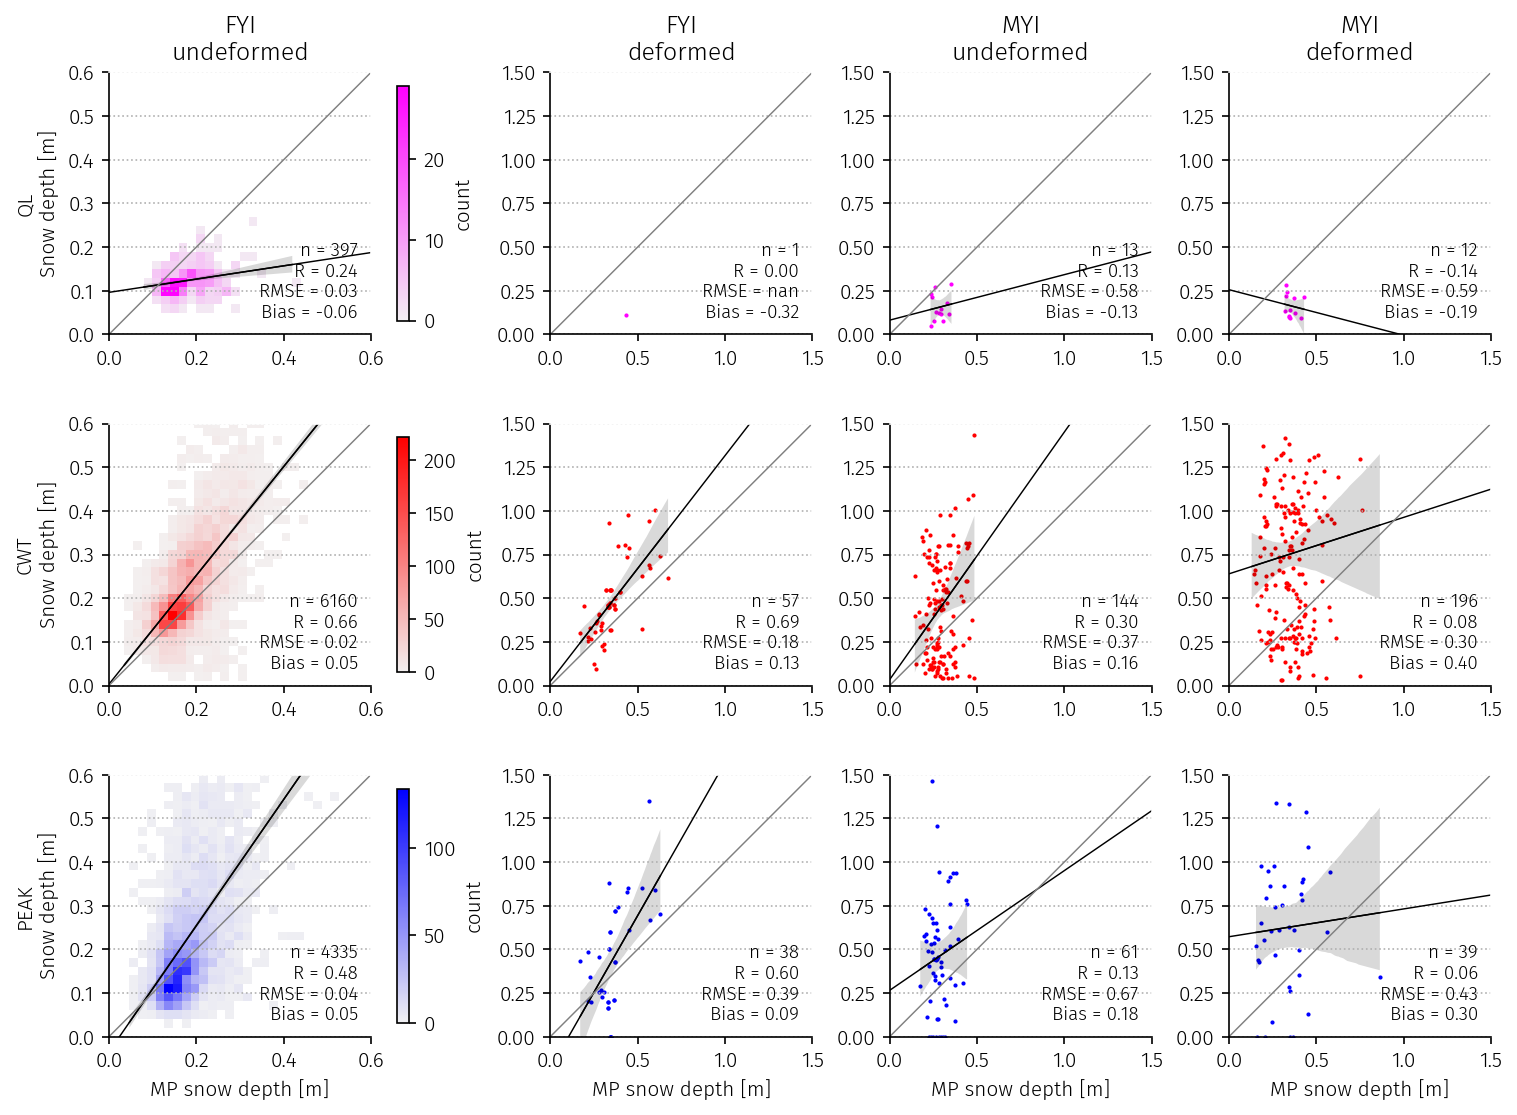

In [140]:
fig, ax = plt.subplots(3,4, constrained_layout=True, figsize=(10,7.4), dpi=150)
xs = np.linspace(0,1.5,100)
colors = ['magenta', 'red', 'blue', 'saddlebrown']
cmaps = [ sns.color_palette("light:magenta", as_cmap=True), sns.color_palette("light:red", as_cmap=True), sns.color_palette("light:blue", as_cmap=True), sns.color_palette("light:saddlebrown", as_cmap=True)]

ax = ax.ravel()
ax[0].set_title('FYI\nundeformed', y=1)
ax[1].set_title('FYI\ndeformed', y=1)
ax[2].set_title('MYI\nundeformed', y=1)
ax[3].set_title('MYI\ndeformed', y=1)

k = 0
color_k = 0

for var in ['snow_depth_QL', 'snow_depth',  'snow_depth_peakiness']:
  
  if var == 'snow_depth_QL':
    mask = (df_supermaster_QL['ice_age'] == 'fyi') & (df_supermaster_QL['deformation_flag'] == 0)
    x = df_supermaster_QL['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]
    y = df_supermaster_QL['snow_depth'][mask]
    
    hist = sns.histplot(x=x,y=y,ax=ax[k],
                cmap=cmaps[color_k],
                bins=30,
                binwidth=.02,
                cbar=True,
                cbar_kws={'shrink': .7, 'label': 'count'},
                stat='count'
                )
    linr = linregress(x,y)
    ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
    sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
    n= len(x)
    bias = np.nanmean(y-x)
    ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
    k+=1
    
    mask = (df_supermaster_QL['ice_age'] == 'fyi') & (df_supermaster_QL['deformation_flag'] == 1)
    x = df_supermaster_QL['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]
    y = df_supermaster_QL['snow_depth'][mask]
    c = df_supermaster_QL['deformation'].apply(lambda x: np.nanmean(x))[mask]
    ax[k].scatter(x, y,
                  color=colors[color_k],
                  s=1
                  )
    if len(x) > 0:
      linr = linregress(x,y)
      ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
      sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
    
      n= len(x)
      bias = np.nanmean(y-x)
      ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
    k+=1

    mask = (df_supermaster_QL['ice_age'] == 'myi') & (df_supermaster_QL['deformation_flag'] == 0)
    x = df_supermaster_QL['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]
    y = df_supermaster_QL['snow_depth'][mask]
    c = df_supermaster_QL['deformation'].apply(lambda x: np.nanmean(x))[mask]
    ax[k].scatter(x, y,
                  color=colors[color_k],
                  s=1
                  )
    if len(x) > 0:
    
      linr = linregress(x,y)
      ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
      sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
      
      n= len(x)
      bias = np.nanmean(y-x)
      ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
    k+=1

    mask = (df_supermaster_QL['ice_age'] == 'myi') & (df_supermaster_QL['deformation_flag'] == 1)
    x = df_supermaster_QL['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]
    y = df_supermaster_QL['snow_depth'][mask]
    c = df_supermaster_QL['deformation'].apply(lambda x: np.nanmean(x))[mask]
    ax[k].scatter(x, y,
                  color=colors[color_k],
                  s=1
                  )
    if len(x) > 0:
    
      linr = linregress(x,y)
      ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
      sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
      
      n= len(x)
      bias = np.nanmean(y-x)
      ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
    k+=1
    color_k+=1
    
  else:
    
    mask = (df_supermaster['ice_age'] == 'fyi') & (df_supermaster['deformation_flag'] == 0)
    x = df_supermaster['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]
    y = df_supermaster[var][mask]
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)]
    x = x[y>0]
    y = y[y>0]
    
    # scat = ax[0].scatter(x, y,
    #             #          c=c,
    #             #   cmap='Reds_r',
    #             #   vmin=0, vmax=1,
    #               s=1
    #               )
    sns.histplot(x=x,y=y,ax=ax[k],
                cmap=cmaps[color_k],
                bins=30,
                binwidth=.02,
                cbar=True,
                stat='count',
                cbar_kws={'shrink': .7, 'label': 'count'},

                )
    
    if len(x) > 0:
      linr = linregress(x,y)
      ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
      sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
      
      n= len(x)
      bias = np.nanmean(y-x)
      ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
          
    k+=1
    mask = (df_supermaster['ice_age'] == 'fyi') & (df_supermaster['deformation_flag'] == 1)
    x = df_supermaster['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]
    y = df_supermaster[var][mask]
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)]
    # c = df_supermaster['deformation'].apply(lambda x: np.nanmean(x))[mask]
    ax[k].scatter(x, y,
                  color=colors[color_k],
                  s=1
                  )
    if len(x) > 0:
      
      linr = linregress(x,y)
      ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
      sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
      
      n= len(x)
      bias = np.nanmean(y-x)
      ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
    k+=1

    mask = (df_supermaster['ice_age'] == 'myi') & (df_supermaster['deformation_flag'] == 0)
    x = df_supermaster['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]
    y = df_supermaster[var][mask]
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)]
    # c = df_supermaster['deformation'].apply(lambda x: np.nanmean(x))[mask]
    ax[k].scatter(x, y,
                  color=colors[color_k],
                  s=1
                  )
    if len(x) > 0:
      linr = linregress(x,y)
      ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
      sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
      
      n= len(x)
      bias = np.nanmean(y-x)
      ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
    k+=1

    mask = (df_supermaster['ice_age'] == 'myi') & (df_supermaster['deformation_flag'] == 1)
    x = df_supermaster['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]
    y = df_supermaster[var][mask]
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)]
    # c = df_supermaster['deformation'].apply(lambda x: np.nanmean(x))[mask]
    ax[k].scatter(x, y,
                  color=colors[color_k],
                  s=1
                  )
    if len(x) > 0:
      linr = linregress(x,y)
      sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
      
      ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
      n= len(x)
      bias = np.nanmean(y-x)
      ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
    k+=1
    color_k+=1
  
 
for i in range(len(ax)):
    ax[i].spines['top'].set_color('white')
    ax[i].spines['right'].set_color('white')
    ax[i].grid(ls=':',axis='y')
    ax[i].set_aspect('equal')
    # ax[i].set_ylabel('SR snow depth [m]')
    ax[i].set_xlim([0, 1.5])
    ax[i].set_ylim([0, 1.5])
    ax[i].plot([0, 1.5], [0, 1.5], color='grey',lw=.7)

    ax[i].set_xlabel('')
    ax[i].set_ylabel('')

ax[0].set_xlim([0, .6])
ax[0].set_ylim([0, .6])
ax[0].set_ylabel('QL\nSnow depth [m]')

ax[4].set_xlim([0, .6])
ax[4].set_ylim([0, .6])
ax[4].set_ylabel('CWT\nSnow depth [m]')

ax[8].set_xlim([0, .6])
ax[8].set_ylim([0, .6])
ax[8].set_ylabel('PEAK\nSnow depth [m]')

# ax[12].set_xlim([0, .6])
# ax[12].set_ylim([0, .6])
# ax[12].set_ylabel('MAX\nSnow depth [m]')


ax[8].set_xlabel('MP snow depth [m]')
ax[9].set_xlabel('MP snow depth [m]')
ax[10].set_xlabel('MP snow depth [m]')
ax[11].set_xlabel('MP snow depth [m]')


Text(0.5, 0, 'MP snow depth [m]')

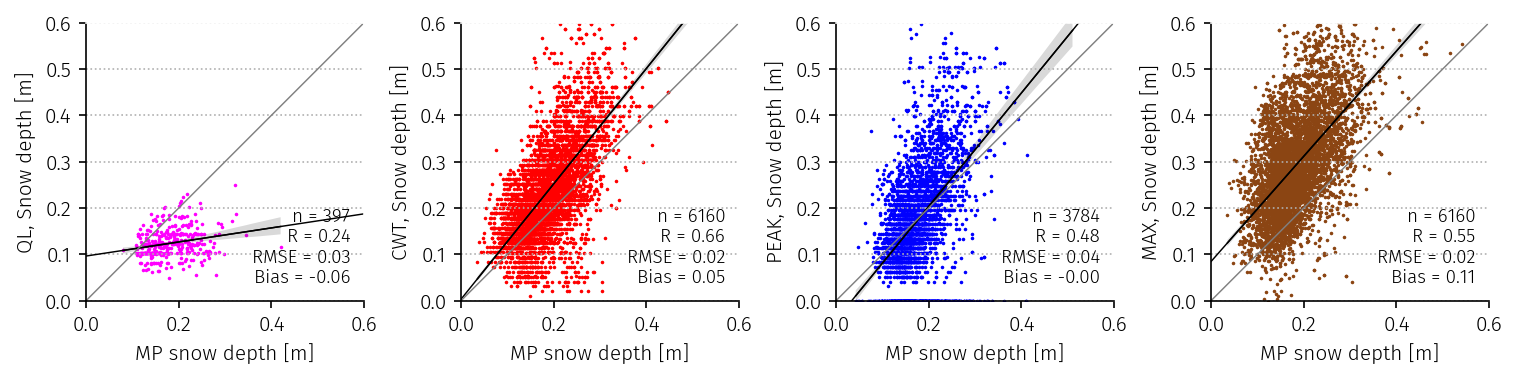

In [9]:
fig, ax = plt.subplots(1,4, constrained_layout=True, figsize=(10,4), dpi=150)
xs = np.linspace(0,1.5,100)

ax = ax.ravel()


k = 0
color_k = 0

for var in ['snow_depth_QL', 'snow_depth',  'snow_depth_peakiness', 'snow_depth_MAX']:
  
  if var == 'snow_depth_QL':
    mask = (df_supermaster_QL['ice_age'] == 'fyi') & (df_supermaster_QL['deformation_flag'] == 0)
    
    x = df_supermaster_QL['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]
    y = df_supermaster_QL['snow_depth'][mask]
    x = x[y>0]
    y = y[y>0]
    scat = ax[k].scatter(x, y, s=.5, color=colors[color_k])
    
    # hist = sns.histplot(x=x,y=y,ax=ax[k],
    #             cmap=cmaps[color_k],
    #             bins=30,
    #             binwidth=.02,
    #             cbar=True,
    #             cbar_kws={'shrink': .7, 'label': 'count'},
    #             stat='count'
    #             )
    linr = linregress(x,y)
    ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
    sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
    n= len(x)
    bias = np.nanmean(y-x)
    ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
    k+=1
    color_k+=1
 
  else:
    
    mask = (df_supermaster['ice_age'] == 'fyi') & (df_supermaster['deformation_flag'] == 0)
    x = df_supermaster['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]
    y = df_supermaster[var][mask]
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)]
    scat = ax[k].scatter(x, y, s=.5, color=colors[color_k])
    # sns.histplot(x=x,y=y,ax=ax[k],
    #             cmap=cmaps[color_k],
    #             bins=30,
    #             binwidth=.02,
    #             cbar=True,
    #             stat='count',
    #             cbar_kws={'shrink': .7, 'label': 'count'},

    #             )
    linr = linregress(x,y)
    ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
    sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
    
    n= len(x)
    bias = np.nanmean(y-x)
    ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
        
    k+=1
    
    color_k+=1
  
 
for i in range(len(ax)):
    ax[i].spines['top'].set_color('white')
    ax[i].spines['right'].set_color('white')
    ax[i].grid(ls=':',axis='y')
    ax[i].set_aspect('equal')
    # ax[i].set_ylabel('SR snow depth [m]')
    ax[i].set_xlim([0, 1.5])
    ax[i].set_ylim([0, 1.5])
    ax[i].plot([0, 1.5], [0, 1.5], color='grey',lw=.7)

    ax[i].set_xlabel('')
    ax[i].set_ylabel('')

ax[0].set_xlim([0, .6])
ax[0].set_ylim([0, .6])
ax[0].set_ylabel('QL, Snow depth [m]')

ax[1].set_xlim([0, .6])
ax[1].set_ylim([0, .6])
ax[1].set_ylabel('CWT, Snow depth [m]')

ax[2].set_xlim([0, .6])
ax[2].set_ylim([0, .6])
ax[2].set_ylabel('PEAK, Snow depth [m]')

ax[3].set_xlim([0, .6])
ax[3].set_ylim([0, .6])
ax[3].set_ylabel('MAX, Snow depth [m]')


ax[0].set_xlabel('MP snow depth [m]')
ax[1].set_xlabel('MP snow depth [m]')
ax[2].set_xlabel('MP snow depth [m]')
ax[3].set_xlabel('MP snow depth [m]')


### which quantile of the in-situ distribution does Wavelet (and Peakiness?) find? Seperated by deformed and undeformed.

In [14]:
deformation_flag = 0
algorithm_flag = 'PEAK'

from collections import Counter


if deformation_flag == 0:
    upper_bound = 0.25
    step = 0.05
else:
    upper_bound = 0.3
    step = 0.1
    
    

def custom_counter(data):
    counter = Counter(data)
    result = {}
    for key, value in counter.items():
        if key >= 1.0:
            result[1.0] = result.get(1.0, 0) + value
        else:
            result[key] = value
    return dict(sorted(result.items()))

def custom_counter2(data, upper_bound=0.6):
    counter = Counter(data)
    result = {}
    for key, value in counter.items():
        if key >= upper_bound:
            result[upper_bound] = result.get(upper_bound, 0) + value
        else:
            result[key] = value
    return dict(sorted(result.items()))


quantiles = []
quantiles_inds = []
non_quantiles = 0
quantiles_sds = []
snow_depths = {}
over_snow_depths = []
under_snow_depths = []
over_inds = []
df_supermaster_subset = df_supermaster.loc[df_supermaster['deformation_flag'] == deformation_flag]
df_supermaster_subset.reset_index(inplace=True, drop=True)
df_supermaster_subset['snow_depth_quantile'] = [0]*len(df_supermaster_subset)
for i in np.arange(0,11,1):
    snow_depths[i] = []
    
for i in trange(len(df_supermaster_subset)):
    
    mask = np.isnan(df_supermaster_subset.loc[i,'MP_snow_depth'])
    quants = pd.qcut(df_supermaster_subset.loc[i,'MP_snow_depth'][~mask], 10)

    sr_sd = df_supermaster_subset.loc[i,'snow_depth_peakiness' if algorithm_flag == 'PEAK' else 'snow_depth']
    
    if True in quants.categories.contains(sr_sd):
        quant = np.argmax(quants.categories.contains(sr_sd))
        quantiles.append(quant)
        snow_depths[quant].append(np.round((quants[quant].right + quants[quant].left)/2, 1))
        df_supermaster_subset.loc[i,'snow_depth_quantile'] = quant * 10

    elif sr_sd > np.max(df_supermaster_subset.loc[i,'MP_snow_depth'][~mask]):
        over_snow_depths.append(np.round((sr_sd - np.max(df_supermaster_subset.loc[i,'MP_snow_depth'][~mask]))/step)*step)
        df_supermaster_subset.loc[i,'snow_depth_quantile'] = 100
        
        over_inds.append(i)
    elif sr_sd < np.min(df_supermaster_subset.loc[i,'MP_snow_depth'][~mask]):
        under_snow_depths.append(np.round((np.min(df_supermaster_subset.loc[i,'MP_snow_depth'][~mask]) - sr_sd)/step)*step)
        df_supermaster_subset.loc[i,'snow_depth_quantile'] = 0
        


snow_depths_counted = {key: custom_counter(values) for key, values in snow_depths.items()}
under_snow_depths_counted = custom_counter2(under_snow_depths, upper_bound)
over_snow_depths_counted = custom_counter2(over_snow_depths, upper_bound)



  0%|          | 0/6304 [00:00<?, ?it/s]

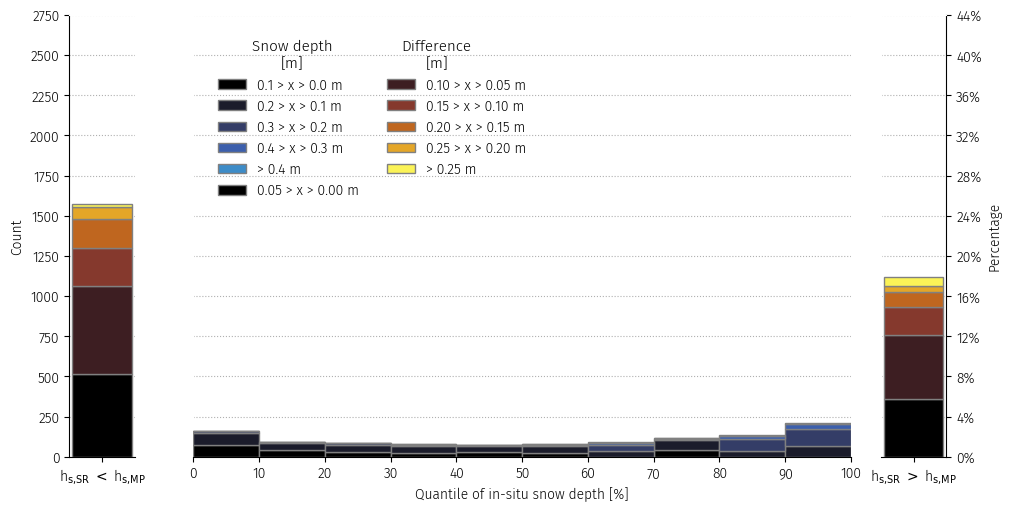

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5), width_ratios=[.1, 1, .1], constrained_layout=True)

# Extract the keys and values from snow_depths_counted
keys1 = list(snow_depths_counted.keys())
values1 = [list(snow_depths_counted[key].values()) for key in keys1]
labels1 = [list(snow_depths_counted[key].keys()) for key in keys1]
keys1 = np.array(keys1) + .5
colors1 = cmr.arctic(np.linspace(0, 1, 8))

# Create a stacked bar chart for the main plot
bottom = np.zeros(len(keys1))

for i in range(len(labels1[9])):
    heights = [values1[j][i] if i < len(values1[j]) else 0 for j in range(len(values1))]
    ax[1].bar(keys1, heights, width=1, bottom=bottom, 
            label=f'{labels1[9][i+1]} > x > {labels1[9][i]} m' if labels1[9][i] != labels1[9][-1] else f'> {labels1[9][i]} m',

              color=colors1[i], edgecolor='grey', zorder=100)
    bottom += heights

# Plot for under_snow_depths as a stacked bar chart
under_keys = [0]  # Single x value
under_values = list(under_snow_depths_counted.values())
under_labels = list(under_snow_depths_counted.keys())
over_keys = [0]  # Single x value
over_values = list(over_snow_depths_counted.values())
over_labels = list(over_snow_depths_counted.keys())
colors2 = cmr.amber(np.linspace(0, 1, len(over_labels)))

bottom = 0
for i in range(len(under_labels)):
    ax[0].bar(under_keys, under_values[i], width=0.1, bottom=bottom, color=colors2[i], edgecolor='grey', zorder=100)
    bottom += under_values[i]
    
# ax[0].set_title('Under Snow Depths')
ax[0].set_xticks([0])
ax[0].set_xticklabels([r'h$_\text{s,SR}$ $<$ h$_\text{s,MP}$'])
# Plot for over_snow_depths as a stacked bar chart

bottom = 0
for i in range(len(over_labels)):
    ax[2].bar(over_keys, over_values[i], width=0.1,
              bottom=bottom,
              label=f'{over_labels[i+1]:.2f} > x > {over_labels[i]:.2f} m' if over_labels[i] != over_labels[-1] else f'> {over_labels[i]:.2f} m',
              color=colors2[i],
              edgecolor='grey',
              zorder=100
              )
    
    bottom += over_values[i]
    
# ax[2].set_title('Over Snow Depths')
ax[2].set_xticks([0])
ax[2].set_xticklabels([r'h$_\text{s,SR}$ $>$ h$_\text{s,MP}$'])
# Set labels and titles

ax[1].set_xlabel('Quantile of in-situ snow depth [%]')
ax[1].set_xticks(np.arange(0, 11, 1))
ax[1].set_xticklabels([f'{(key) * 10:.0f}' for key in np.arange(0, 11, 1)])
ax[0].set_ylabel('Count')
fig.legend(frameon=False, loc='upper left', bbox_to_anchor=(0.2, .88), ncols=2)

# Set x-axis limits
ax[1].set_xlim(0, 10)

# Set grid and spine colors
# for a in ax:
ax[0].spines['top'].set_color('white')
ax[0].spines['right'].set_color('white')
ax[0].grid(ls=':', axis='y')

ax[1].spines['top'].set_color('white')
ax[1].spines['right'].set_color('white')
ax[1].spines['left'].set_color('white')
ax[1].tick_params(axis='y', colors='white')
ax[1].grid(ls=':', axis='y')

ax[2].spines['top'].set_color('white')
ax[2].spines['left'].set_color('white')
ax[2].grid(ls=':', axis='y')

ax[2].yaxis.tick_right()

# ax[1].spines['left'].set_color('white')
# ax[2].spines['left'].set_color('white')
# ax[2].tick_params(axis='y', colors='white')
ax[1].text(0.15, .945, 'Snow depth\n[m]', transform=ax[1].transAxes, ha='center', va='top',fontsize=11)
ax[1].text(0.37, .945, 'Difference\n[m]', transform=ax[1].transAxes, ha='center', va='top', fontsize=11)

ys = np.arange(0, 3000, 250)

ax[0].set_yticks(ys)
ax[1].set_yticks(ys)
ax[2].set_yticks(ys)

ax[0].set_yticklabels([f'{i}' for i in ys])
ax[2].set_yticklabels([f'{i / len(df_supermaster_subset)*100:.0f}%' for i in ys])

ax[2].set_ylabel('Percentage', )
ax[2].yaxis.set_label_position("right")


ax[0].set_ylim(min(ys), max(ys))
ax[1].set_ylim(min(ys), max(ys))
ax[2].set_ylim(min(ys), max(ys))

plt.show()

### Where do things go wrong (overestimation basically). Remember it is only undeformed

### correcting CWT based on 90% quantile

(0.0, 0.9)

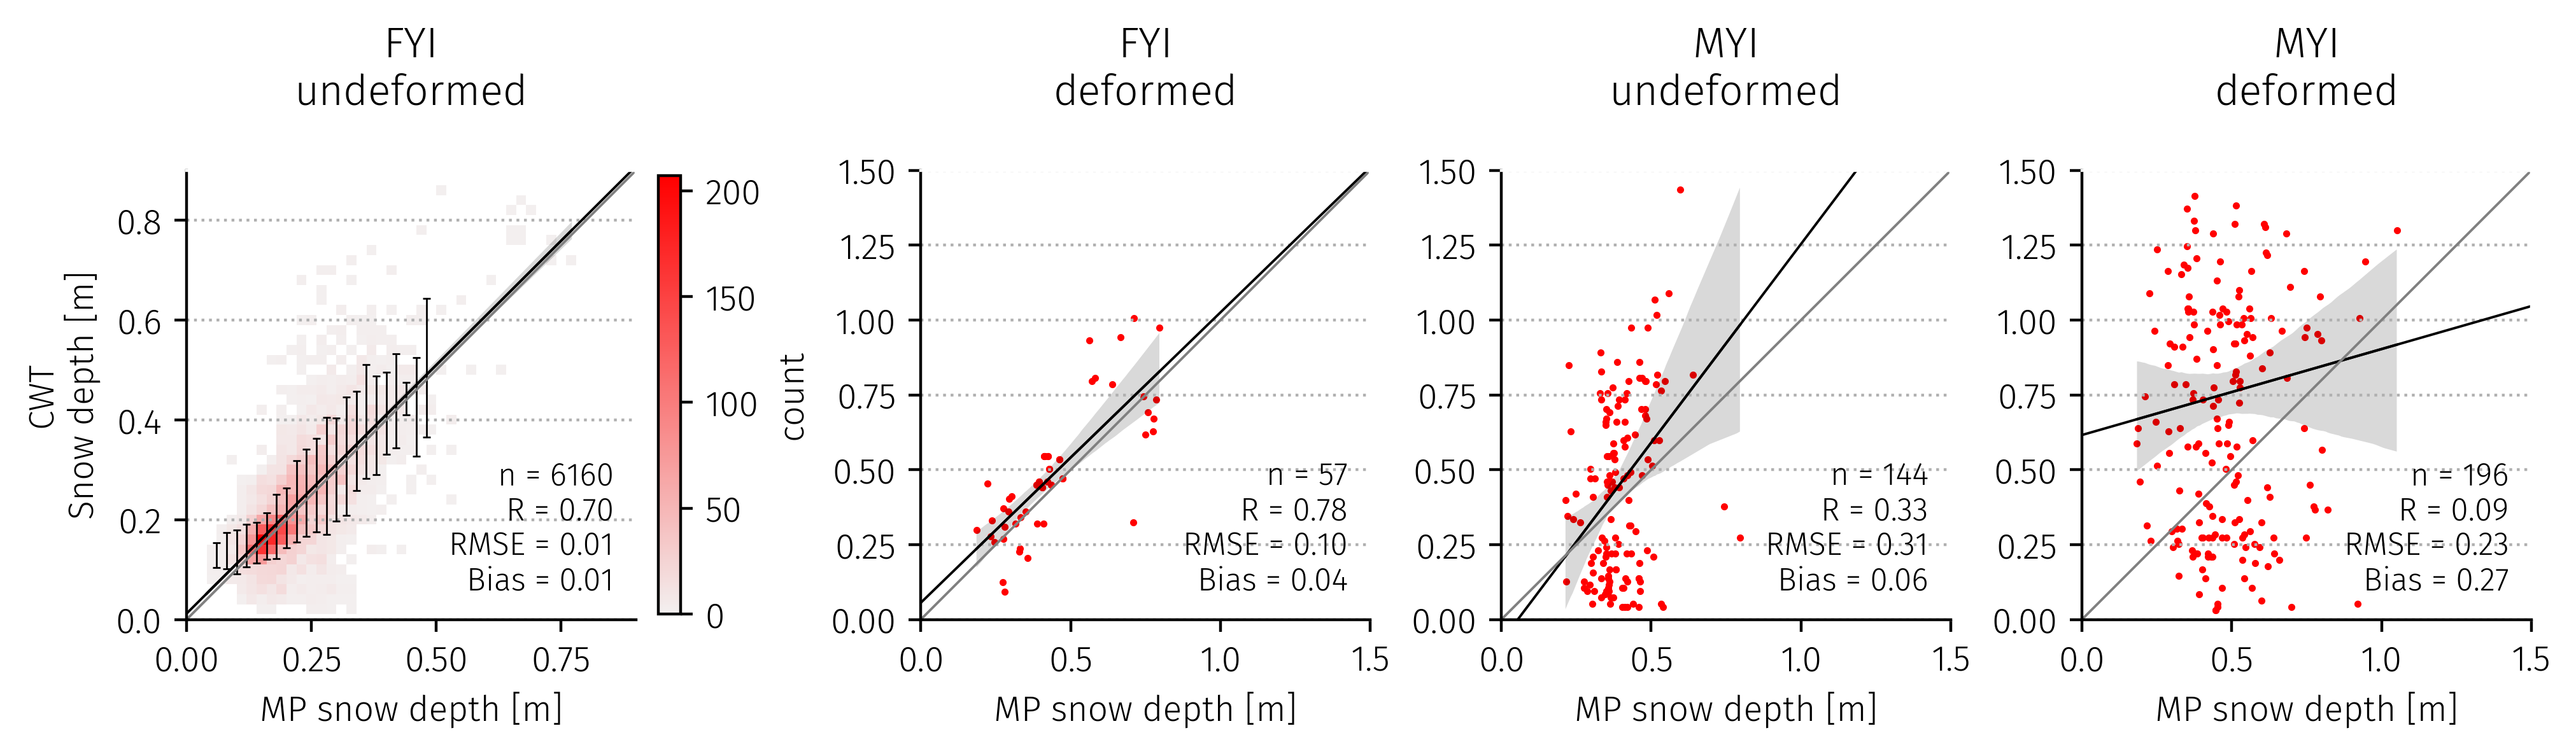

In [16]:
fig, ax = plt.subplots(1, 4, figsize=(10, 5), dpi=400, constrained_layout=True)
var = 'snow_depth'
# var = 'snow_depth_peakiness'
    
ax[0].set_title('FYI\nundeformed', y=1.1)
ax[1].set_title('FYI\ndeformed', y=1.1)
ax[2].set_title('MYI\nundeformed', y=1.1)
ax[3].set_title('MYI\ndeformed', y=1.1)
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[2].set_aspect('equal')
ax[3].set_aspect('equal')

q = .9
# mask = (df_supermaster['ice_age'] == 'fyi') & (df_supermaster['deformation_flag'] == 0)
# x = df_supermaster['MP_snow_depth'].apply(lambda x: np.nanquantile(x,.9))[mask]
# y = df_supermaster['snow_depth'][mask]
# ax[0].scatter(x,y)


mask = (df_supermaster['ice_age'] == 'fyi') & (df_supermaster['deformation_flag'] == 0)
x = df_supermaster['MP_snow_depth'].apply(lambda x: np.nanquantile(x,.9))[mask]
y = df_supermaster[var][mask]
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]
x = x[y>0]
y = y[y>0]
sns.histplot(x=x,y=y,ax=ax[0],
            cmap=cmaps[1],
            bins=30,
            binwidth=.02,
            cbar=True,
            stat='count',
            cbar_kws={'shrink': .35, 'label': 'count'},

            )
linr = linregress(x,y)
ax[0].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
sns.regplot(x=x, y=y, ax=ax[0], scatter=False, color='black', line_kws={'lw':.7})

n= len(x)
bias = np.nanmean(y-x)
ax[0].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[0].transAxes, ha='right', va='bottom', size=9)

uncertainties= {}
for k in np.arange(0,1,0.02):
  if len(y[(x > k-0.01) & (x < k + .01)]) > 5:
    ax[0].errorbar(k, np.mean(y[(x > k-0.01) & (x < k + .01)]), yerr= np.std(y[(x > k-0.01) & (x < k + .01)]), color='black', capsize=1, capthick=.5, lw=.5)
    uncertainties[k] = np.std(y[(x > k-0.01) & (x < k + .01)])
###################

mask = (df_supermaster['ice_age'] == 'fyi') & (df_supermaster['deformation_flag'] == 1)
x = df_supermaster['MP_snow_depth'].apply(lambda x: np.nanquantile(x,.9))[mask]
y = df_supermaster[var][mask]
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]
x = x[y>0]
y = y[y>0]
ax[1].scatter(x,y, s=1, color='red')
linr = linregress(x,y)
ax[1].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
sns.regplot(x=x, y=y, ax=ax[1], scatter=False, color='black', line_kws={'lw':.7})

n= len(x)
bias = np.nanmean(y-x)
ax[1].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[1].transAxes, ha='right', va='bottom', size=9)


#######

mask = (df_supermaster['ice_age'] == 'myi') & (df_supermaster['deformation_flag'] == 0)
x = df_supermaster['MP_snow_depth'].apply(lambda x: np.nanquantile(x,.9))[mask]
y = df_supermaster[var][mask]
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]
x = x[y>0]
y = y[y>0]
ax[2].scatter(x,y, s=1, color='red')

linr = linregress(x,y)
ax[2].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
sns.regplot(x=x, y=y, ax=ax[2], scatter=False, color='black', line_kws={'lw':.7})

n= len(x)
bias = np.nanmean(y-x)
ax[2].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[2].transAxes, ha='right', va='bottom', size=9)


#######

mask = (df_supermaster['ice_age'] == 'myi') & (df_supermaster['deformation_flag'] == 1)
x = df_supermaster['MP_snow_depth'].apply(lambda x: np.nanquantile(x,.9))[mask]
y = df_supermaster[var][mask]
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]
x = x[y>0]
y = y[y>0]
ax[3].scatter(x,y, s=1, color='red')

linr = linregress(x,y)
ax[3].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
sns.regplot(x=x, y=y, ax=ax[3], scatter=False, color='black', line_kws={'lw':.7})

n= len(x)
bias = np.nanmean(y-x)
ax[3].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[3].transAxes, ha='right', va='bottom', size=9)


for i in range(len(ax)):
    ax[i].spines['top'].set_color('white')
    ax[i].spines['right'].set_color('white')
    ax[i].grid(ls=':',axis='y')
    ax[i].set_aspect('equal')
    # ax[i].set_ylabel('SR snow depth [m]')
    ax[i].set_xlim([0, 1.5])
    ax[i].set_ylim([0, 1.5])
    ax[i].plot([0, 1.5], [0, 1.5], color='grey',lw=.7)

    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    
ax[0].set_ylabel('CWT\nSnow depth [m]')
# ax[1].set_ylabel('CWT, Snow depth [m]')
# ax[2].set_ylabel('CWT, Snow depth [m]')
# ax[3].set_ylabel('CWT, Snow depth [m]')

# ax[0].set_xlabel('MP snow depth\n(90% quantile) [m]')
# ax[1].set_xlabel('MP snow depth\n(90% quantile) [m]')
# ax[2].set_xlabel('MP snow depth\n(90% quantile) [m]')
# ax[3].set_xlabel('MP snow depth\n(90% quantile) [m]')

ax[0].set_xlabel('MP snow depth [m]')
ax[1].set_xlabel('MP snow depth [m]')
ax[2].set_xlabel('MP snow depth [m]')
ax[3].set_xlabel('MP snow depth [m]')


ax[0].set_xlim([0, .9])
ax[0].set_ylim([0, .9])

In [27]:
import pickle

with open('uncertainties_cwt.pkl', 'wb') as f:
    pickle.dump(uncertainties, f)

(0.0, 0.9)

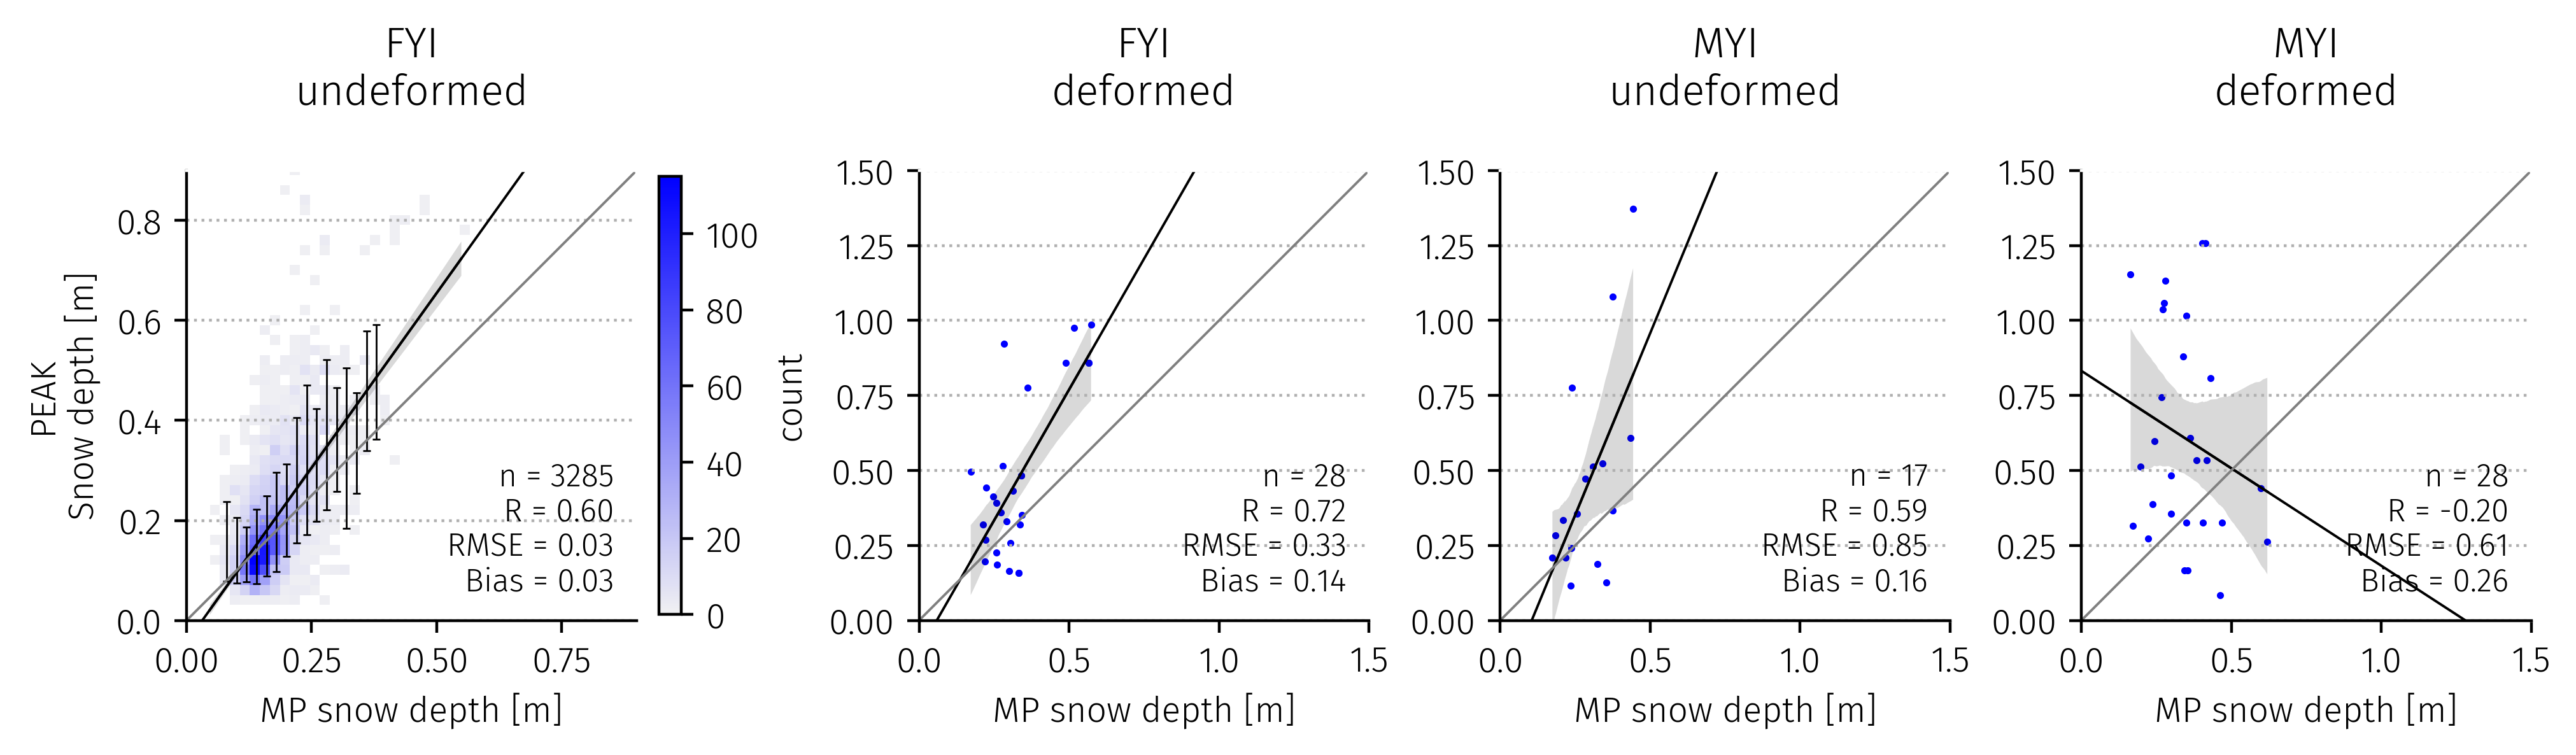

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(10, 5), dpi=400, constrained_layout=True)
# var = 'snow_depth'
var = 'snow_depth_peakiness'
    
ax[0].set_title('FYI\nundeformed', y=1.1)
ax[1].set_title('FYI\ndeformed', y=1.1)
ax[2].set_title('MYI\nundeformed', y=1.1)
ax[3].set_title('MYI\ndeformed', y=1.1)
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[2].set_aspect('equal')
ax[3].set_aspect('equal')

q = .9
# mask = (df_supermaster['ice_age'] == 'fyi') & (df_supermaster['deformation_flag'] == 0)
# x = df_supermaster['MP_snow_depth'].apply(lambda x: np.nanquantile(x,.9))[mask]
# y = df_supermaster['snow_depth'][mask]
# ax[0].scatter(x,y)


mask = (df_supermaster['ice_age'] == 'fyi') & (df_supermaster['deformation_flag'] == 0)
x = df_supermaster['MP_snow_depth'].apply(lambda x: np.nanquantile(x,.5))[mask]
y = df_supermaster[var][mask]
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]
x = x[y>0]
y = y[y>0]
sns.histplot(x=x,y=y,ax=ax[0],
            cmap=cmaps[2],
            bins=30,
            binwidth=.02,
            cbar=True,
            stat='count',
            cbar_kws={'shrink': .35, 'label': 'count'},

            )
linr = linregress(x,y)
ax[0].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
sns.regplot(x=x, y=y, ax=ax[0], scatter=False, color='black', line_kws={'lw':.7})

n= len(x)
bias = np.nanmean(y-x)
ax[0].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[0].transAxes, ha='right', va='bottom', size=9)

uncertainties= {}
for k in np.arange(0,1,0.02):
  if len(y[(x > k-0.01) & (x < k + .01)]) > 5:
    ax[0].errorbar(k, np.mean(y[(x > k-0.01) & (x < k + .01)]), yerr= np.std(y[(x > k-0.01) & (x < k + .01)]), color='black', capsize=1, capthick=.5, lw=.5)
    uncertainties[k] = np.std(y[(x > k-0.01) & (x < k + .01)])
###################

mask = (df_supermaster['ice_age'] == 'fyi') & (df_supermaster['deformation_flag'] == 1)
x = df_supermaster['MP_snow_depth'].apply(lambda x: np.nanquantile(x,.5))[mask]
y = df_supermaster[var][mask]
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]
x = x[y>0]
y = y[y>0]
ax[1].scatter(x,y, s=1, color='blue')
linr = linregress(x,y)
ax[1].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
sns.regplot(x=x, y=y, ax=ax[1], scatter=False, color='black', line_kws={'lw':.7})

n= len(x)
bias = np.nanmean(y-x)
ax[1].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[1].transAxes, ha='right', va='bottom', size=9)


#######

mask = (df_supermaster['ice_age'] == 'myi') & (df_supermaster['deformation_flag'] == 0)
x = df_supermaster['MP_snow_depth'].apply(lambda x: np.nanquantile(x,.5))[mask]
y = df_supermaster[var][mask]
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]
x = x[y>0]
y = y[y>0]
ax[2].scatter(x,y, s=1, color='blue')

linr = linregress(x,y)
ax[2].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
sns.regplot(x=x, y=y, ax=ax[2], scatter=False, color='black', line_kws={'lw':.7})

n= len(x)
bias = np.nanmean(y-x)
ax[2].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[2].transAxes, ha='right', va='bottom', size=9)


#######

mask = (df_supermaster['ice_age'] == 'myi') & (df_supermaster['deformation_flag'] == 1)
x = df_supermaster['MP_snow_depth'].apply(lambda x: np.nanquantile(x,.5))[mask]
y = df_supermaster[var][mask]
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]
x = x[y>0]
y = y[y>0]
ax[3].scatter(x,y, s=1, color='blue')

linr = linregress(x,y)
ax[3].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
sns.regplot(x=x, y=y, ax=ax[3], scatter=False, color='black', line_kws={'lw':.7})

n= len(x)
bias = np.nanmean(y-x)
ax[3].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[3].transAxes, ha='right', va='bottom', size=9)


for i in range(len(ax)):
    ax[i].spines['top'].set_color('white')
    ax[i].spines['right'].set_color('white')
    ax[i].grid(ls=':',axis='y')
    ax[i].set_aspect('equal')
    # ax[i].set_ylabel('SR snow depth [m]')
    ax[i].set_xlim([0, 1.5])
    ax[i].set_ylim([0, 1.5])
    ax[i].plot([0, 1.5], [0, 1.5], color='grey',lw=.7)

    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    
ax[0].set_ylabel('PEAK\nSnow depth [m]')
# ax[1].set_ylabel('CWT, Snow depth [m]')
# ax[2].set_ylabel('CWT, Snow depth [m]')
# ax[3].set_ylabel('CWT, Snow depth [m]')

# ax[0].set_xlabel('MP snow depth\n(90% quantile) [m]')
# ax[1].set_xlabel('MP snow depth\n(90% quantile) [m]')
# ax[2].set_xlabel('MP snow depth\n(90% quantile) [m]')
# ax[3].set_xlabel('MP snow depth\n(90% quantile) [m]')

ax[0].set_xlabel('MP snow depth [m]')
ax[1].set_xlabel('MP snow depth [m]')
ax[2].set_xlabel('MP snow depth [m]')
ax[3].set_xlabel('MP snow depth [m]')


ax[0].set_xlim([0, .9])
ax[0].set_ylim([0, .9])

In [30]:
import pickle

with open('uncertainties_PEAK.pkl', 'wb') as f:
    pickle.dump(uncertainties, f)

### RECONSTRUCTING THE MEAN BASED ON QUANTILE ASSUMPTION

In [18]:
from scipy.stats import skewnorm

def get_std_from_mean(mean_depth, grad):
    std = mean_depth * grad
    return (std)


def depth_distribution_from_mean(mean_depth, dep_bin_edges, statistics):
    
    dep_bin_centres = dep_bin_edges[:-1] + (dep_bin_edges[1] - dep_bin_edges[0]) / 2

    std = get_std_from_mean(mean_depth, statistics['stats'])

    std_bin_edges = (dep_bin_edges - mean_depth) / std
    std_bin_centres = std_bin_edges[:-1] + (std_bin_edges[1] - std_bin_edges[0]) / 2
    std_bw = np.nanmean(np.diff(std_bin_edges))

    fit = skewnorm.pdf(std_bin_centres,
                       statistics['a'],
                       statistics['loc'],
                       statistics['scale']) * std_bw

    return (dep_bin_centres, fit)


0.902527627785827
0.8850402571389938
0.8952400472772256
0.8574839327581737


(0.0, 0.7)

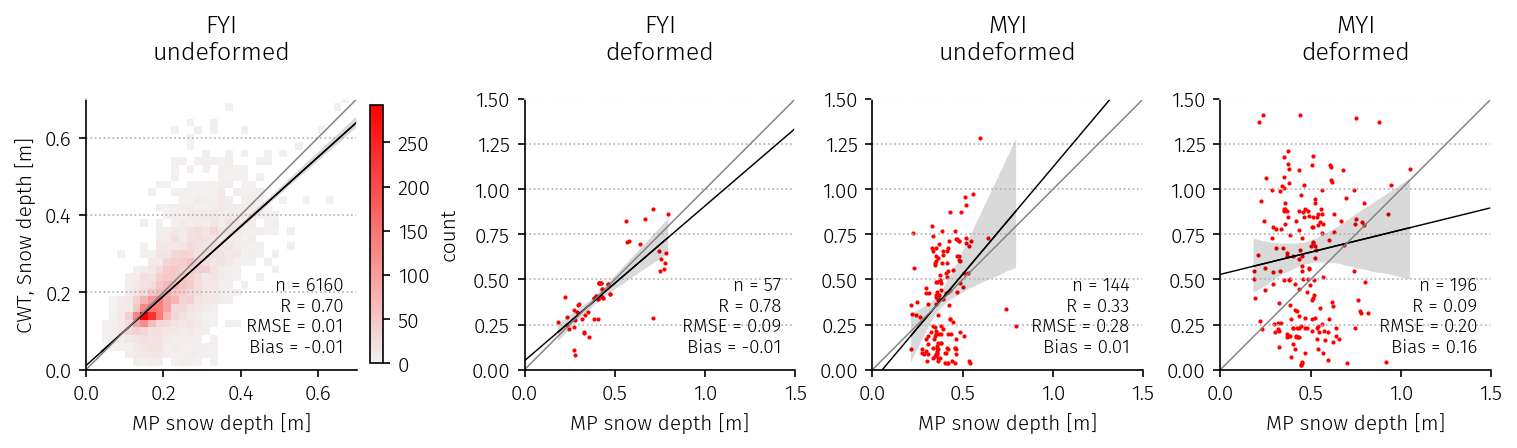

In [19]:
q = .8
norm = 'lognorm'
fig, ax = plt.subplots(1, 4, figsize=(10, 5), dpi=150, constrained_layout=True)

    
ax[0].set_title('FYI\nundeformed', y=1.1)
ax[1].set_title('FYI\ndeformed', y=1.1)
ax[2].set_title('MYI\nundeformed', y=1.1)
ax[3].set_title('MYI\ndeformed', y=1.1)
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[2].set_aspect('equal')
ax[3].set_aspect('equal')

# mask = (df_supermaster['ice_age'] == 'fyi') & (df_supermaster['deformation_flag'] == 0)
# x = df_supermaster['MP_snow_depth'].apply(lambda x: np.nanquantile(x,.9))[mask]
# y = df_supermaster['snow_depth'][mask]
# ax[0].scatter(x,y)


mask = (df_supermaster['ice_age'] == 'fyi') & (df_supermaster['deformation_flag'] == 0)
x = df_supermaster['MP_snow_depth'].apply(lambda x: np.nanquantile(x,.9))[mask]
y = df_supermaster['snow_depth'][mask]
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]

statistics = pickle.load(open(f'/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/distributions/statistics_{norm}_fyi_undeformed.p','rb'))

tiny_bin_edges = np.arange(0,5,0.001)
mean_depths = np.arange(0.1,1.5,0.005)

quan80 = []
for mean_depth in mean_depths:

    bc, ft = depth_distribution_from_mean(mean_depth, tiny_bin_edges, statistics=statistics)
    thresh80arg = np.argmax(np.cumsum(ft)>q) #Calculate index of 80% quantile; You could set another number here (90%,75%, whatever)
    thresh80dep = tiny_bin_edges[thresh80arg] #Convert index to snow depth
    quan80.append( thresh80dep )

lr = linregress(quan80,mean_depths)
conversion_factor = lr.slope
print(conversion_factor)

y = y * conversion_factor    
df_supermaster.loc[list(mask[mask==True].index), 'corrected_snow_depth'] = y

sns.histplot(x=x,y=y,ax=ax[0],
            cmap=cmaps[1],
            bins=30,
            binwidth=.02,
            cbar=True,
            stat='count',
            cbar_kws={'shrink': .35, 'label': 'count'},

            )
linr = linregress(x,y)
ax[0].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
sns.regplot(x=x, y=y, ax=ax[0], scatter=False, color='black', line_kws={'lw':.7})

n= len(x)
bias = np.nanmean(y-x)
ax[0].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[0].transAxes, ha='right', va='bottom', size=9)



###################

mask = (df_supermaster['ice_age'] == 'fyi') & (df_supermaster['deformation_flag'] == 1)
x = df_supermaster['MP_snow_depth'].apply(lambda x: np.nanquantile(x,.9))[mask]
y = df_supermaster['snow_depth'][mask]
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]

statistics = pickle.load(open(f'/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/distributions/statistics_{norm}_fyi_deformed.p','rb'))

tiny_bin_edges = np.arange(0,5,0.001)
mean_depths = np.arange(0.1,1.5,0.005)

quan80 = []
for mean_depth in mean_depths:

    bc, ft = depth_distribution_from_mean(mean_depth, tiny_bin_edges, statistics=statistics)
    thresh80arg = np.argmax(np.cumsum(ft)>q) #Calculate index of 80% quantile; You could set another number here (90%,75%, whatever)
    thresh80dep = tiny_bin_edges[thresh80arg] #Convert index to snow depth
    quan80.append( thresh80dep )

lr = linregress(quan80,mean_depths)
conversion_factor = lr.slope
print(conversion_factor)
y = y * conversion_factor    
df_supermaster.loc[list(mask[mask==True].index), 'corrected_snow_depth'] = y

ax[1].scatter(x,y, s=1, color='red')
linr = linregress(x,y)
ax[1].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
sns.regplot(x=x, y=y, ax=ax[1], scatter=False, color='black', line_kws={'lw':.7})

n= len(x)
bias = np.nanmean(y-x)
ax[1].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[1].transAxes, ha='right', va='bottom', size=9)


#######

mask = (df_supermaster['ice_age'] == 'myi') & (df_supermaster['deformation_flag'] == 0)
x = df_supermaster['MP_snow_depth'].apply(lambda x: np.nanquantile(x,.9))[mask]
y = df_supermaster['snow_depth'][mask]
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]

statistics = pickle.load(open(f'/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/distributions/statistics_{norm}_myi_undeformed.p','rb'))

tiny_bin_edges = np.arange(0,5,0.001)
mean_depths = np.arange(0.1,1.5,0.005)

quan80 = []
for mean_depth in mean_depths:

    bc, ft = depth_distribution_from_mean(mean_depth, tiny_bin_edges, statistics=statistics)
    thresh80arg = np.argmax(np.cumsum(ft)>q) #Calculate index of 80% quantile; You could set another number here (90%,75%, whatever)
    thresh80dep = tiny_bin_edges[thresh80arg] #Convert index to snow depth
    quan80.append( thresh80dep )

lr = linregress(quan80,mean_depths)
conversion_factor = lr.slope
print(conversion_factor)

y = y * conversion_factor    
df_supermaster.loc[list(mask[mask==True].index), 'corrected_snow_depth'] = y

ax[2].scatter(x,y, s=1, color='red')

linr = linregress(x,y)
ax[2].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
sns.regplot(x=x, y=y, ax=ax[2], scatter=False, color='black', line_kws={'lw':.7})

n= len(x)
bias = np.nanmean(y-x)
ax[2].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[2].transAxes, ha='right', va='bottom', size=9)


#######

mask = (df_supermaster['ice_age'] == 'myi') & (df_supermaster['deformation_flag'] == 1)
x = df_supermaster['MP_snow_depth'].apply(lambda x: np.nanquantile(x,.9))[mask]
y = df_supermaster['snow_depth'][mask]
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]


statistics = pickle.load(open(f'/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/distributions/statistics_{norm}_myi_deformed.p','rb'))

tiny_bin_edges = np.arange(0,5,0.001)
mean_depths = np.arange(0.1,1.5,0.005)

quan80 = []
for mean_depth in mean_depths:

    bc, ft = depth_distribution_from_mean(mean_depth, tiny_bin_edges, statistics=statistics)
    thresh80arg = np.argmax(np.cumsum(ft)>q) #Calculate index of 80% quantile; You could set another number here (90%,75%, whatever)
    thresh80dep = tiny_bin_edges[thresh80arg] #Convert index to snow depth
    quan80.append( thresh80dep )

lr = linregress(quan80, mean_depths)
conversion_factor = lr.slope
print(conversion_factor)

y = y * conversion_factor    
df_supermaster.loc[list(mask[mask==True].index), 'corrected_snow_depth'] = y

ax[3].scatter(x,y, s=1, color='red')

linr = linregress(x,y)
ax[3].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
sns.regplot(x=x, y=y, ax=ax[3], scatter=False, color='black', line_kws={'lw':.7})

n= len(x)
bias = np.nanmean(y-x)
ax[3].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[3].transAxes, ha='right', va='bottom', size=9)


for i in range(len(ax)):
    ax[i].spines['top'].set_color('white')
    ax[i].spines['right'].set_color('white')
    ax[i].grid(ls=':',axis='y')
    ax[i].set_aspect('equal')
    # ax[i].set_ylabel('SR snow depth [m]')
    ax[i].set_xlim([0, 1.5])
    ax[i].set_ylim([0, 1.5])
    ax[i].plot([0, 1.5], [0, 1.5], color='grey',lw=.7)

    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    
ax[0].set_ylabel('CWT, Snow depth [m]')
# ax[1].set_ylabel('CWT, Snow depth [m]')
# ax[2].set_ylabel('CWT, Snow depth [m]')
# ax[3].set_ylabel('CWT, Snow depth [m]')

ax[0].set_xlabel('MP snow depth [m]')
ax[1].set_xlabel('MP snow depth [m]')
ax[2].set_xlabel('MP snow depth [m]')
ax[3].set_xlabel('MP snow depth [m]')

ax[0].set_xlim([0, .7])
ax[0].set_ylim([0, .7])


### PLOTTING AN EXAMPLE FOOTPRINT AND DISTRIBUTION

In [57]:
df_supermaster

,time,radar_data,SNR,wavelet_coefs_log,wavelet_coefs_lin,elevation_axii,noise,altitude,roll,pitch,...,ATM_elev_rolled_17,MP_snow_depth_rolled_21,MP_snow_depth_uncertainty_rolled_21,ATM_elev_rolled_21,MP_snow_depth_rolled_25,MP_snow_depth_uncertainty_rolled_25,ATM_elev_rolled_25,ATM_elev_wavelet,ATM_elev_peakiness,snow_depth_MAX
0,2014-03-25 17:04:23,0.001340,-2.029374,0.0,0.0,10.024013,0.002139,476.498109,-0.521598,-0.086941,...,"[0.041276455, 0.027563095, 0.026565552, 0.1108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.041276455, 0.027563095, 0.026565552, 0.1108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.041276455, 0.027563095, 0.026565552, 0.1108...","[0.023970295, 0.07904737, 0.023970295, -0.1388...","[0.018955968, 0.074033044, 0.018955968, -0.143...",0.250688
1,2014-03-25 17:04:23,0.002049,0.687601,0.0,0.0,10.024013,0.001749,476.498670,-0.514009,-0.087452,...,"[0.041276455, 0.027563095, 0.026565552, 0.1108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.041276455, 0.027563095, 0.026565552, 0.1108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.041276455, 0.027563095, 0.026565552, 0.1108...","[-0.040397238, -0.057388693, -0.033462595, -0....","[-0.045411564, -0.06240302, -0.03847692, -0.07...",0.361400
2,2014-03-25 17:04:23,0.001621,-0.973084,0.0,0.0,10.024013,0.002028,476.499310,-0.506808,-0.088884,...,"[0.041276455, 0.027563095, 0.026565552, 0.1108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.041276455, 0.027563095, 0.026565552, 0.1108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.041276455, 0.027563095, 0.026565552, 0.1108...","[-0.07525189, -0.089397505, -0.11266191, -0.06...","[-0.080266215, -0.09441183, -0.117676236, -0.0...",0.312595
3,2014-03-25 17:04:23,0.000902,-3.737421,0.0,0.0,10.024013,0.002132,476.487471,-0.499484,-0.090051,...,"[0.041276455, 0.027563095, 0.026565552, 0.1108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.041276455, 0.027563095, 0.026565552, 0.1108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.041276455, 0.027563095, 0.026565552, 0.1108...","[-0.027525734, -0.121662214, -0.05792561, -0.0...","[-0.03254006, -0.12667653, -0.06293994, -0.068...",0.259047
4,2014-03-25 17:04:23,0.002095,-0.541726,0.0,0.0,10.024013,0.002374,476.488315,-0.489335,-0.092400,...,"[0.041276455, 0.027563095, 0.026565552, 0.1108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.041276455, 0.027563095, 0.026565552, 0.1108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.041276455, 0.027563095, 0.026565552, 0.1108...","[0.15408127, 0.15727346, 0.102860376, 0.013851...","[0.14906695, 0.15225914, 0.09784605, 0.0088374...",0.386601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6552,2016-04-19 15:33:19,0.013789,-0.548980,0.0,0.0,9.989874,0.015648,519.615738,-2.262375,0.781672,...,"[0.052232742, 0.24716091, -0.058710575, -0.058...","[0.2669871537842682, 0.24937481900597655, 0.29...","[0.0072627361651009924, 0.0063746709754915875,...","[0.0629518, 0.008282185, 0.0863266, 0.0863266,...","[0.2787466546051856, 0.43611953633762024, 0.41...","[0.00664197006394265, 0.0064941148126981246, 0...","[-0.078710556, -0.053526163, -0.17576742, -0.1...","[0.2700711, 0.739688, 0.49411494, 0.49411494, ...","[0.44376537, 0.9133823, 0.66780925, 0.66780925...",0.967136
6553,2016-04-19 15:33:20,0.048919,5.326483,0.0,0.0,9.989874,0.014349,519.617804,-2.241144,0.780846,...

In [96]:
%matplotlib widget

grid7 1


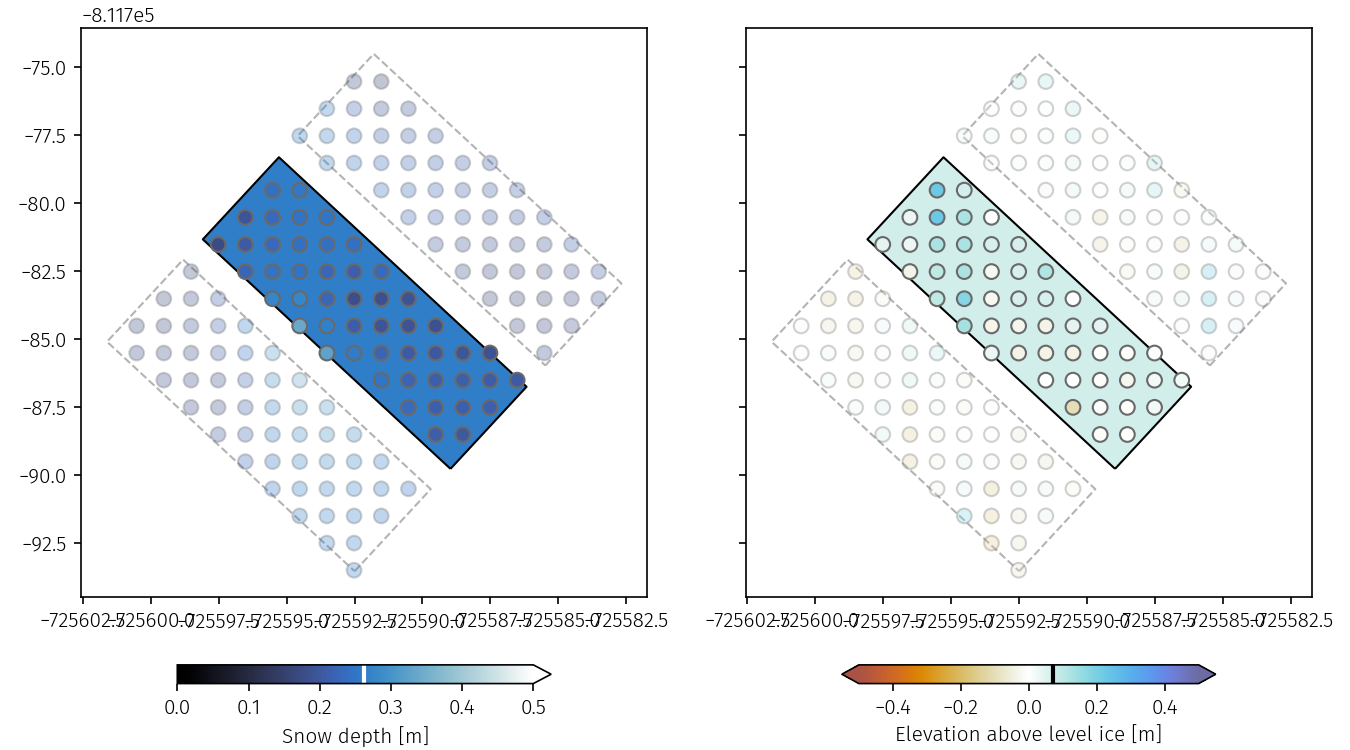

In [110]:
ind = 5634
print(df_supermaster.loc[ind,'site'], df_supermaster.loc[ind,'overflight_nr'])
norm = mcolors.Normalize(vmin=0, vmax=.5)
cmap = cmr.arctic
fig, ax = plt.subplots(1, 2, figsize=(9, 5), dpi=150, constrained_layout=True, sharex=True, sharey=True)
ax[0].set_aspect('equal')
# ax[0].axis('off')

plot_polygon(ax[0], df_supermaster.loc[ind,'footprints'], edgecolor='black', facecolor=cmap(norm(df_supermaster.loc[ind,'snow_depth'])))
ax[0].scatter(df_supermaster.loc[ind,'grid_x'], df_supermaster.loc[ind,'grid_y'], c=df_supermaster.loc[ind,'MP_snow_depth'], s=50, cmap=cmap, norm=norm, edgecolor='dimgrey')


plot_polygon(ax[0], df_supermaster.loc[ind-1,'footprints'], edgecolor='dimgrey', facecolor='none', alpha=.5, ls='--')
ax[0].scatter(df_supermaster.loc[ind-1,'grid_x'], df_supermaster.loc[ind-1,'grid_y'], c=df_supermaster.loc[ind-1,'MP_snow_depth'], s=50, cmap=cmap, norm=norm, edgecolor='dimgrey', alpha=.3)

plot_polygon(ax[0], df_supermaster.loc[ind+1,'footprints'], edgecolor='dimgrey', facecolor='none', alpha=.5, ls='--')
ax[0].scatter(df_supermaster.loc[ind+1,'grid_x'], df_supermaster.loc[ind+1,'grid_y'], c=df_supermaster.loc[ind+1,'MP_snow_depth'], s=50, cmap=cmap, norm=norm, edgecolor='dimgrey', alpha=.3)

# ax[0].set_xlim(xlims)
# ax[0].set_ylim(ylims)

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[0], label='Snow depth [m]', orientation='horizontal', shrink=.6, extend='max')
cbar.ax.axvline(df_supermaster.loc[ind,'snow_depth'], color='white', lw=2)


norm = mcolors.TwoSlopeNorm(vmin=-.5, vcenter=0, vmax=.5)
cmap = cmr.prinsenvlag
ax[1].set_aspect('equal')
# ax[1].axis('off')

plot_polygon(ax[1], df_supermaster.loc[ind,'footprints'], edgecolor='black', facecolor=cmap(norm(df_supermaster.loc[ind,'air_snow_elevation'])))
ax[1].scatter(df_supermaster.loc[ind,'grid_x'], df_supermaster.loc[ind,'grid_y'], c=df_supermaster.loc[ind,'ATM_elev'], s=50, cmap=cmap, norm=norm, edgecolor='dimgrey')

plot_polygon(ax[1], df_supermaster.loc[ind-1,'footprints'], edgecolor='dimgrey', facecolor='none', alpha=.5, ls='--')
ax[1].scatter(df_supermaster.loc[ind-1,'grid_x'], df_supermaster.loc[ind-1,'grid_y'], c=df_supermaster.loc[ind-1,'ATM_elev'], s=50, cmap=cmap, norm=norm, edgecolor='dimgrey', alpha=.3)

plot_polygon(ax[1], df_supermaster.loc[ind+1,'footprints'], edgecolor='dimgrey', facecolor='none',  alpha=.5, ls='--')
ax[1].scatter(df_supermaster.loc[ind+1,'grid_x'], df_supermaster.loc[ind+1,'grid_y'], c=df_supermaster.loc[ind+1,'ATM_elev'], s=50, cmap=cmap, norm=norm, edgecolor='dimgrey', alpha=.3)


cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[1], label='Elevation above level ice [m]', orientation='horizontal', shrink=.6, extend='both')
cbar.ax.axvline(df_supermaster.loc[ind,'air_snow_elevation'], color='black', lw=2)


In [45]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection

def plot_polygon(ax, poly, **kwargs):
    path = Path.make_compound_path(
        Path(np.asarray(poly.exterior.coords)[:, :2]),
        *[Path(np.asarray(ring.coords)[:, :2]) for ring in poly.interiors])

    patch = PathPatch(path, **kwargs)
    collection = PatchCollection([patch], **kwargs)
    
    ax.add_collection(collection, autolim=True)
    ax.autoscale_view()
    return collection

### REPLOTTING HISTOGRAMS

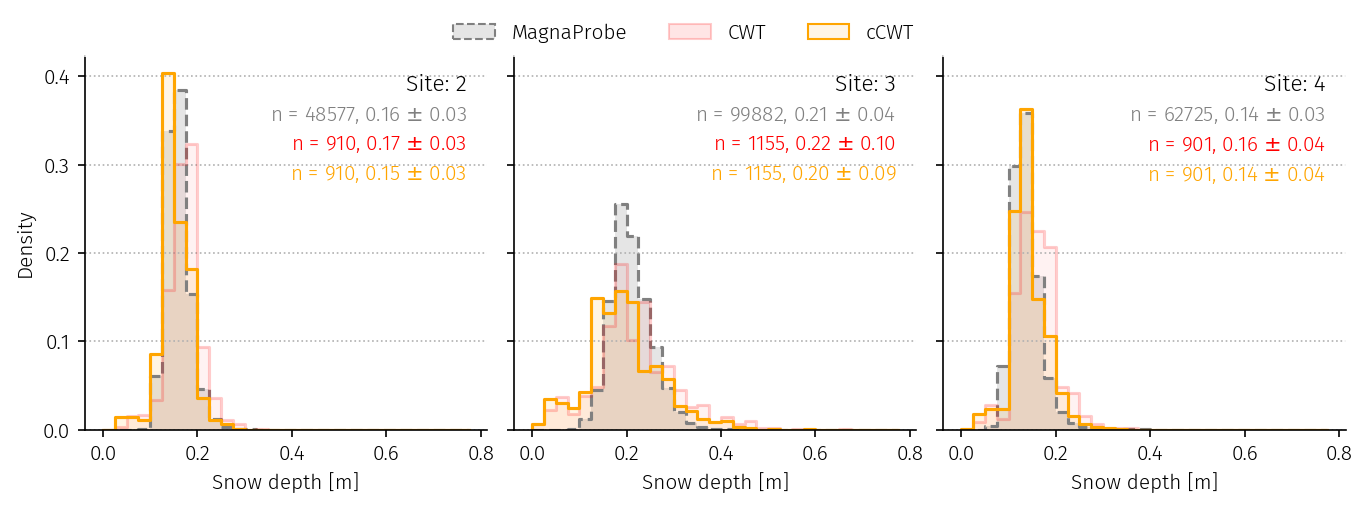

Text(0, 0.5, 'Density')

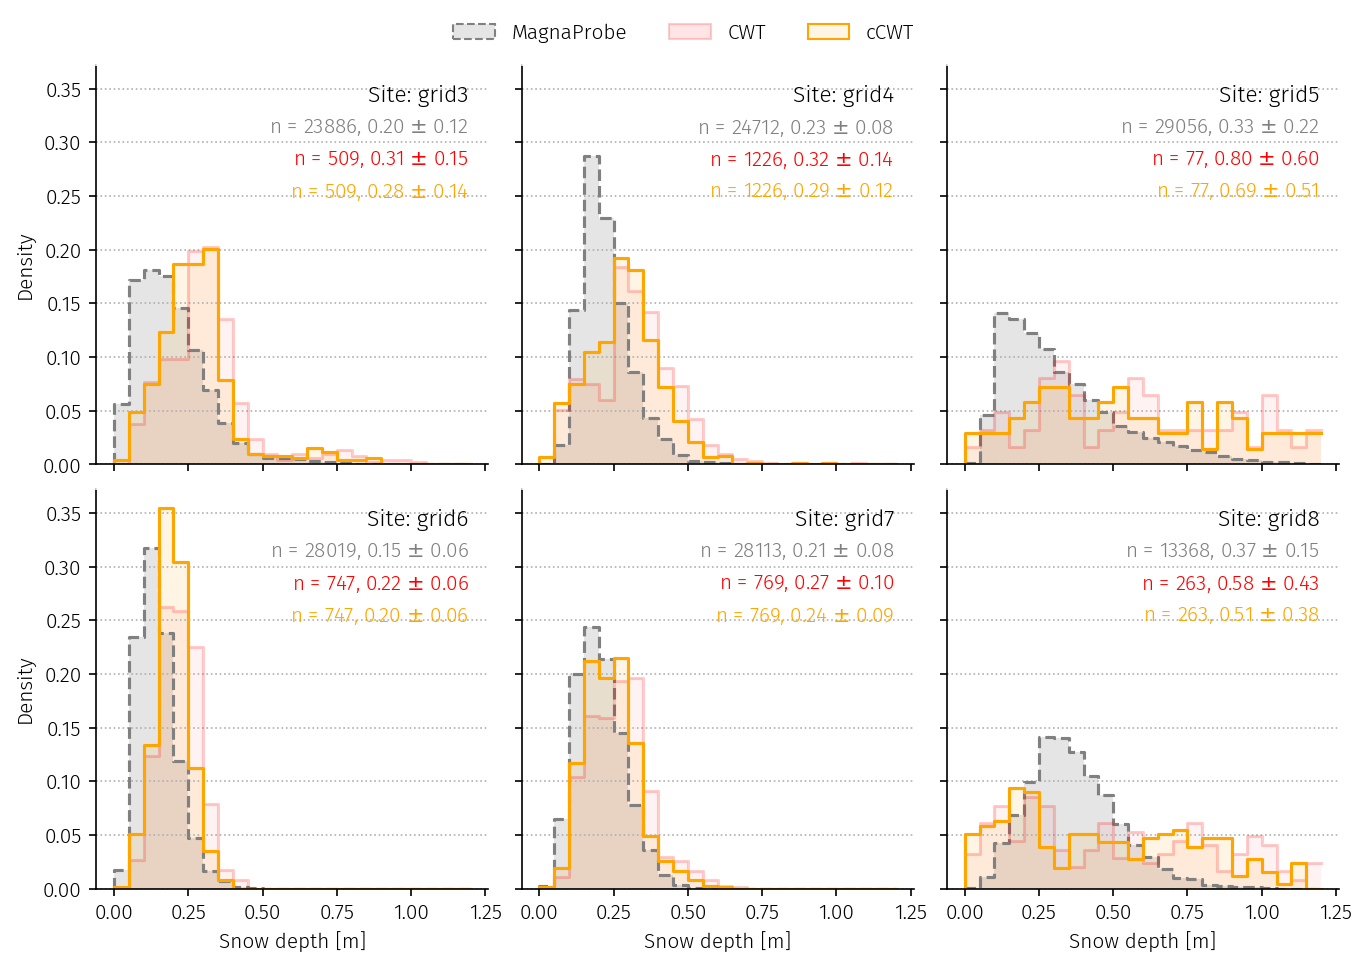

In [20]:
from matplotlib.patches import Patch

sites_2014 = [2,3,4]

fig, ax = plt.subplots(1,3, figsize=(9,3), sharey=True, sharex=True, constrained_layout=True, dpi=150)
ax = ax.ravel()
bw = 0.025
bin_edges = np.arange(0,.8,bw)
bc = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2

for i in range(len(ax)):
    ax[i].spines['top'].set_color('white')
    ax[i].spines['right'].set_color('white')
    ax[i].grid(ls=':',axis='y')
    
ax[0].set_xlabel('Snow depth [m]')
ax[1].set_xlabel('Snow depth [m]')
ax[2].set_xlabel('Snow depth [m]')

for i, site in enumerate(sites_2014):
    df_f = df_supermaster.loc[df_supermaster['site'] == site]
    df_f.reset_index(inplace=True, drop=True)
    
    #Kriged MagnaProbe snow depths
    hist, bin_edges = np.histogram(MP_data_dict[site]['snow_depth'].values, bins=bin_edges, density=True)
    ax[i].step([0]+list(bc+bw/2), [0]+list(hist*bw),color='grey', ls='--',)
    t = ax[i].bar(bc, hist*bw,
                width=bw,
                alpha=.2,
                color='grey'
                )
    ax[i].text(0.95, 0.95, f'Site: {site}', transform=ax[i].transAxes, ha='right', va='top', size=11)
    
    n = len(MP_data_dict[site]['snow_depth'].values[~np.isnan(MP_data_dict[site]['snow_depth'])])
    mean = np.nanmean(MP_data_dict[site]['snow_depth'])
    std = np.nanstd(MP_data_dict[site]['snow_depth'])
    ax[i].text(0.95, 0.87, f'n = {n}, {mean:.2f} $\pm$ {std:.2f}', transform=ax[i].transAxes, ha='right', va='top', color='grey')
    
    
    #WAVELET
    hist, bin_edges = np.histogram(df_f['snow_depth'], bins=bin_edges, density=True)
    ax[i].step([0]+list(bc+bw/2), [0]+list(hist*bw),color='red',alpha=.2)
    t = ax[i].bar(bc, hist*bw,
                width=bw,
                alpha=.05,
                color='red',
                )
    n = len(df_f['snow_depth'].loc[~np.isnan(df_f['snow_depth'])])
    mean = np.nanmean(df_f['snow_depth'])
    std = np.nanstd(df_f['snow_depth'])
    ax[i].text(0.95, 0.79, f'n = {n}, {mean:.2f} $\pm$ {std:.2f}', transform=ax[i].transAxes, ha='right', va='top', color='red')
    
    
    #CORRECTED WAVELET
    hist, bin_edges = np.histogram(df_f['corrected_snow_depth'], bins=bin_edges, density=True)
    ax[i].step([0]+list(bc+bw/2), [0]+list(hist*bw),color='orange')
    t = ax[i].bar(bc, hist*bw,
                width=bw,
                alpha=.1,
                color='orange',
                )
    n = len(df_f['corrected_snow_depth'].loc[~np.isnan(df_f['corrected_snow_depth'])])
    mean = np.nanmean(df_f['corrected_snow_depth'])
    std = np.nanstd(df_f['corrected_snow_depth'])
    ax[i].text(0.95, 0.71, f'n = {n}, {mean:.2f} $\pm$ {std:.2f}', transform=ax[i].transAxes, ha='right', va='top', color='orange')
    

legend_elements = [Patch(facecolor=mcolors.to_rgba('grey', alpha=.2), edgecolor='grey', label='MagnaProbe', linestyle='--'),
                   Patch(facecolor=mcolors.to_rgba('red', alpha=.1), edgecolor=mcolors.to_rgba('red', alpha=.2), label='CWT'),
                   Patch(facecolor=mcolors.to_rgba('orange', alpha=.1), edgecolor='orange', label='cCWT'),
                   
                   ]
fig.legend(handles=legend_elements, ncols=5, loc='upper center', bbox_to_anchor=(0.5, 1.1), frameon=False)
# fig.legend(handles=legend_elements)
ax[0].set_ylabel('Density')
plt.show()





####

# 2016

###
sites_2016 = ['grid3', 'grid4', 'grid5', 'grid6', 'grid7', 'grid8']


fig, ax = plt.subplots(2,3, figsize=(9,6), sharey=True, sharex=True, constrained_layout=True, dpi=150)
ax = ax.ravel()
bw = 0.05
bin_edges = np.arange(0,1.25,bw)
bc = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2

for i in range(len(ax)):
    ax[i].spines['top'].set_color('white')
    ax[i].spines['right'].set_color('white')
    ax[i].grid(ls=':',axis='y')
    
ax[3].set_xlabel('Snow depth [m]')
ax[4].set_xlabel('Snow depth [m]')
ax[5].set_xlabel('Snow depth [m]')

for i, site in enumerate(sites_2016):
    df_f = df_supermaster.loc[df_supermaster['site'] == site]
    df_f.reset_index(inplace=True, drop=True)
    
    #Kriged MagnaProbe snow depths
    hist, bin_edges = np.histogram(MP_data_dict[site]['snow_depth'].values, bins=bin_edges, density=True)
    ax[i].step([0]+list(bc+bw/2), [0]+list(hist*bw),color='grey', ls='--')
    t = ax[i].bar(bc, hist*bw,
                width=bw,
                alpha=.2,
                color='grey'
                )
    ax[i].text(0.95, 0.95, f'Site: {site}', transform=ax[i].transAxes, ha='right', va='top', size=11)
    
    n = len(MP_data_dict[site]['snow_depth'].values[~np.isnan(MP_data_dict[site]['snow_depth'])])
    mean = np.nanmean(MP_data_dict[site]['snow_depth'])
    std = np.nanstd(MP_data_dict[site]['snow_depth'])
    ax[i].text(0.95, 0.87, f'n = {n}, {mean:.2f} $\pm$ {std:.2f}', transform=ax[i].transAxes, ha='right', va='top', color='grey')
    
    
    #WAVELET
    hist, bin_edges = np.histogram(df_f['snow_depth'], bins=bin_edges, density=True)
    ax[i].step([0]+list(bc+bw/2), [0]+list(hist*bw),color='red',alpha=.2)
    t = ax[i].bar(bc, hist*bw,
                width=bw,
                alpha=.05,
                color='red',
                )
    n = len(df_f['snow_depth'].loc[~np.isnan(df_f['snow_depth'])])
    mean = np.nanmean(df_f['snow_depth'])
    std = np.nanstd(df_f['snow_depth'])
    ax[i].text(0.95, 0.79, f'n = {n}, {mean:.2f} $\pm$ {std:.2f}', transform=ax[i].transAxes, ha='right', va='top', color='red')
 
    #CORRECTED WAVELET
    hist, bin_edges = np.histogram(df_f['corrected_snow_depth'], bins=bin_edges, density=True)
    ax[i].step([0]+list(bc+bw/2), [0]+list(hist*bw),color='orange')
    t = ax[i].bar(bc, hist*bw,
                width=bw,
                alpha=.1,
                color='orange',
                )
    n = len(df_f['corrected_snow_depth'].loc[~np.isnan(df_f['corrected_snow_depth'])])
    mean = np.nanmean(df_f['corrected_snow_depth'])
    std = np.nanstd(df_f['corrected_snow_depth'])
    ax[i].text(0.95, 0.71, f'n = {n}, {mean:.2f} $\pm$ {std:.2f}', transform=ax[i].transAxes, ha='right', va='top', color='orange')
    

legend_elements = [Patch(facecolor=mcolors.to_rgba('grey', alpha=.2), edgecolor='grey', label='MagnaProbe', linestyle='--'),
                   Patch(facecolor=mcolors.to_rgba('red', alpha=.1), edgecolor=mcolors.to_rgba('red', alpha=.2), label='CWT'),
                   Patch(facecolor=mcolors.to_rgba('orange', alpha=.1), edgecolor='orange', label='cCWT'),
                   ]


fig.legend(handles=legend_elements, ncols=5, loc='upper center', bbox_to_anchor=(0.5, 1.06), frameon=False)
# fig.legend(handles=legend_elements)
ax[0].set_ylabel('Density')
ax[3].set_ylabel('Density')